In [386]:
# basic
import math
from math import pi
import numpy as np
import pandas as pd
from os import path
from PIL import Image
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
# stats
from bioinfokit.analys import stat
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

monster_df = pd.read_csv('../data/processed/1_Monster_Dataset.csv')

monster_df.drop(columns={"Monster Name.1","Unnamed: 0"},axis=1, inplace=True)
monster_df.head()

Monster Name    Size       Type     Alignment  \
0   Adult Green Dragon    Huge     dragon   lawful evil   
1  Adult Silver Dragon    Huge     dragon   lawful good   
2   Adult White Dragon    Huge     dragon  chaotic evil   
3        Air Elemental   Large  elemental       neutral   
4                  Ape  Medium      beast     unaligned   

                                              Traits Reactions  Armor Class  \
0  ['Amphibious. The dragon can breathe air and w...    ['NA']           19   
1  ['Legendary Resistance (3/Day). If the dragon ...    ['NA']           19   
2  ["Ice Walk. The dragon can move across and cli...    ['NA']           18   
3  ["Air Form. The elemental can enter a hostile ...    ['NA']           15   
4                                              [nan]    ['NA']           12   

   Hit Points                                           Speed  Challenge  ...  \
0         207                 40 ft., fly 80 ft., swim 40 ft.       15.0  ...   
1         243                              40 ft., fly 80 ft.       16.0  ...   
2         200  40 ft., burrow 30 ft., fly 80 ft., swim 40 ft.       13.0  ...   
3          90                       0 ft., fly 90 ft. (hover)        5.0  ...   
4          19                            30 ft., climb 30 ft.        0.5  ...   

   Damage Vulnerabilities  Spellcaster  Magic Resistance  \
0                       0          0.0               0.0   
1                       0          0.0               0.0   
2                       0          0.0               0.0   
3                       0          0.0               0.0   
4                       0          0.0               0.0   

   Legendary Resistance  Regeneration  Undead Fortitude  Pack Tactics  \
0                   1.0           0.0               0.0           0.0   
1                   1.0           0.0               0.0           0.0   
2                   1.0           0.0               0.0           0.0   
3                   0.0           0.0               0.0           0.0   
4                   0.0           0.0               0.0           0.0   

  Damage Transfer Angelic Weapons Charge  
0             0.0             0.0    0.0  
1             0.0             0.0    0.0  
2             0.0             0.0    0.0  
3             0.0             0.0    0.0  
4             0.0             0.0    0.0  

[5 rows x 55 columns]

## Monster Stat Block Insights

### Dataset: Numerics Stats only

C:\Users\ingal\AppData\Local\Temp\ipykernel_18560\1096787799.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  monster_df.iloc[:,0:29].hist(ax=ax);


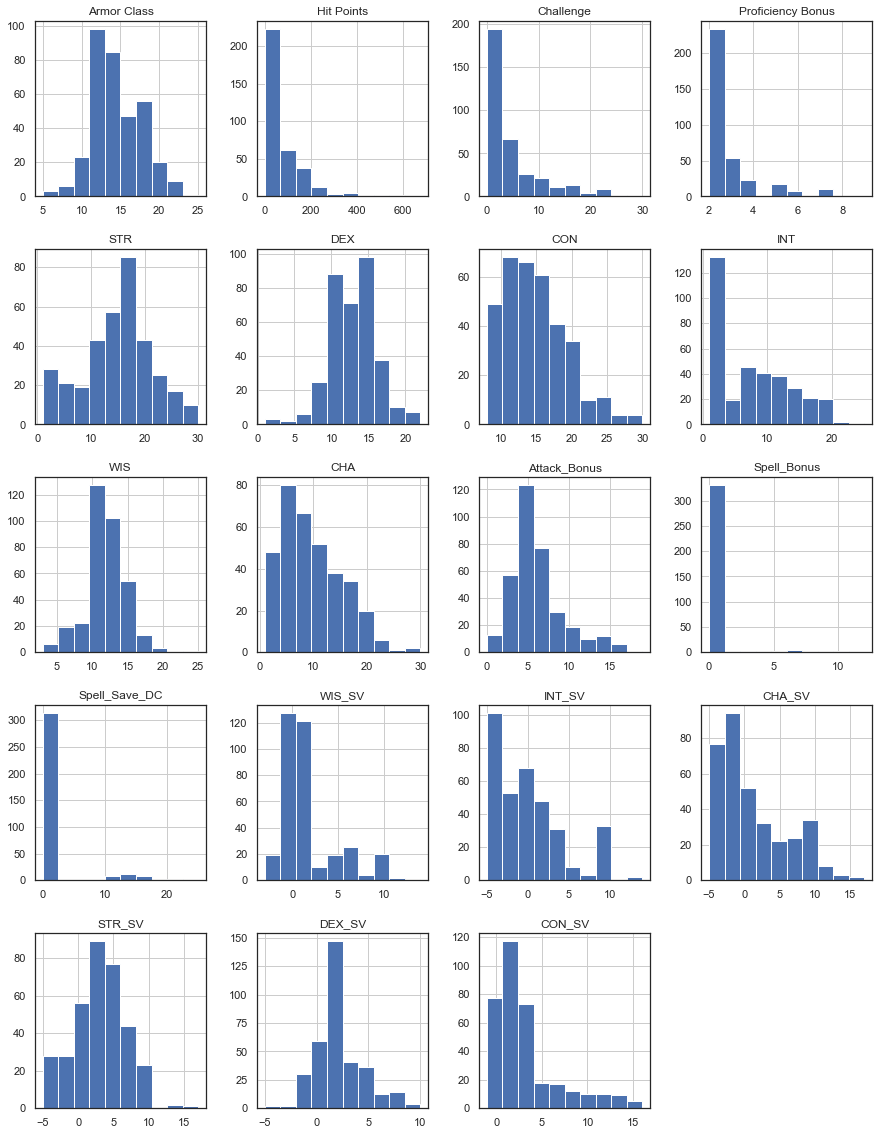

In [387]:
#Trim dataset quick histogram to necessary stats
fig = plt.figure(figsize = (15,20));
ax = fig.gca();
monster_df.iloc[:,0:29].hist(ax=ax);

Based on the Challenege Rating and Hit points, we have a very skewed dataset. That's totally ok! Most campaigns don't go past lvl 15 usually, so it makes sense wizards would have more lower CR monsters. Also, just rationally, a world with just as many high CR monsters sounds scary AF. 

However, I can see Armor class seems to follow a somewhat normal distributions, same with Dex, STR, and WIS. CHA, CON, INT are also very right tail skewed. We expect this from Proficiency bonus since that goes hand in hand with Challenege rating.

The right-skewed natures makes sense, considering there are more monsters at lower-levels

### Comparing stats vs stats using scatter plots

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


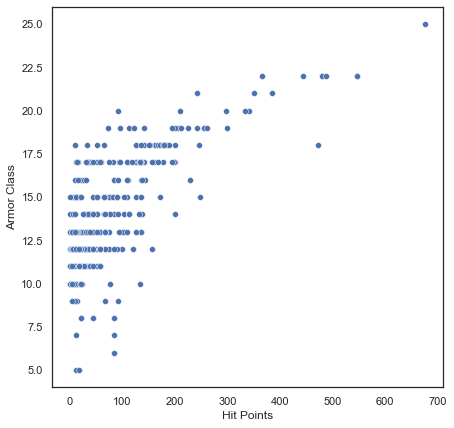

In [388]:
fig = plt.figure(figsize = (7,7));
ax = sns.scatterplot(monster_df["Hit Points"], monster_df["Armor Class"])

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


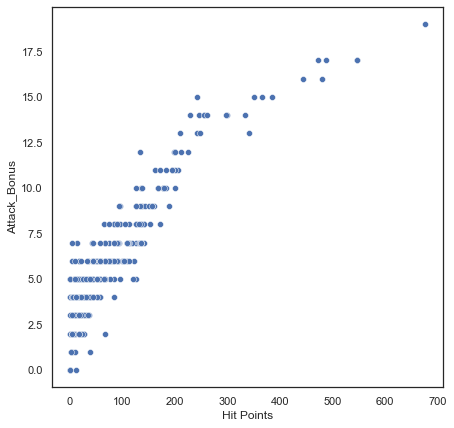

In [389]:
fig = plt.figure(figsize = (7,7));
ax = sns.scatterplot(monster_df["Hit Points"], monster_df["Attack_Bonus"])

### Saving Throw vs. Challenge Ratings

In [390]:
# Saving Throw DataFrame
saving_throw_df = pd.melt(monster_df, id_vars = ['Challenge'],value_vars=[ 'STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV'])
saving_throw_df.columns = ['Challenge','Saving Throw', 'value']

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


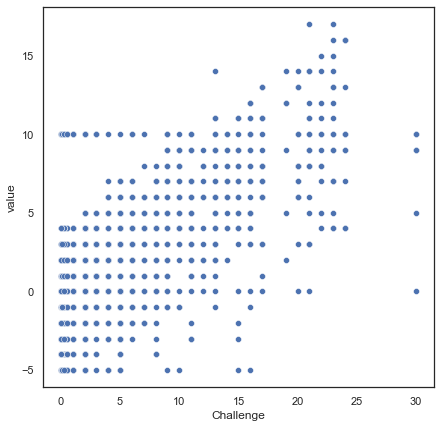

In [391]:
fig = plt.figure(figsize = (7,7));
ax = sns.scatterplot(saving_throw_df["Challenge"], saving_throw_df["value"])

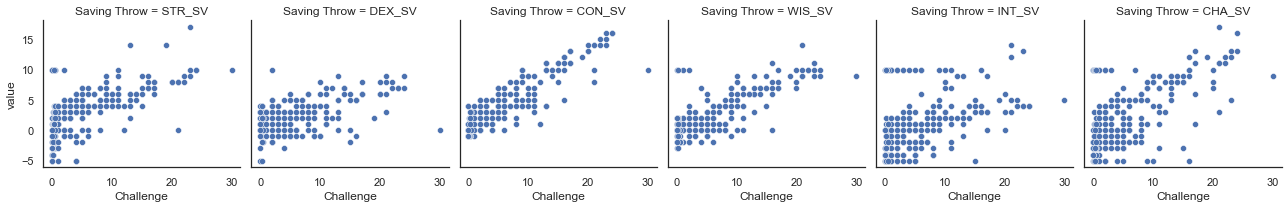

In [392]:
g = sns.FacetGrid(saving_throw_df, col="Saving Throw")
g.map_dataframe(sns.scatterplot, x="Challenge", y="value")

Out of all the saving throws, it looks like Dexerity has the least correlation and also the lowest value at higher levels.

### Stats vs. Challenge Ratings

In [393]:
#Stats dataframe
stats_challenge_df = pd.melt(monster_df, id_vars = ['Challenge'],value_vars=[ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'])
stats_challenge_df.columns = ['Challenge','Stats', 'value']

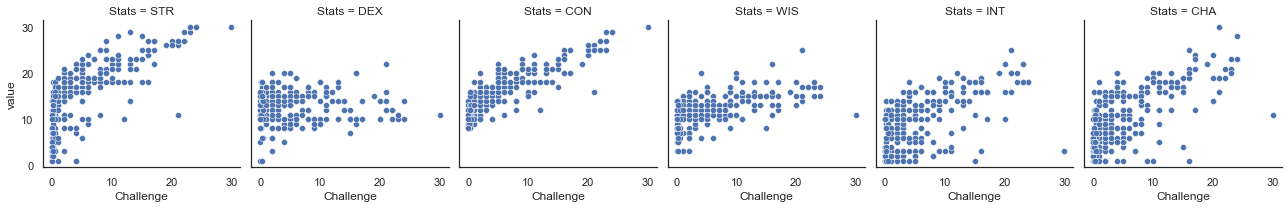

In [394]:
g = sns.FacetGrid(stats_challenge_df, col="Stats")
g.map_dataframe(sns.scatterplot, x="Challenge", y="value")

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


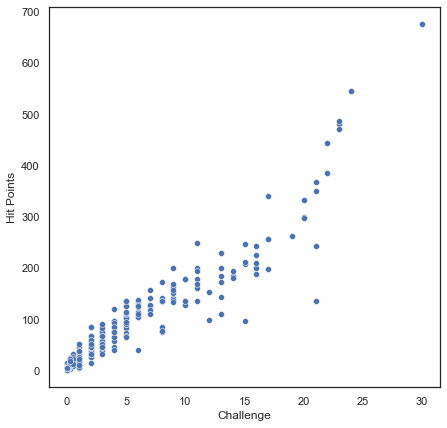

In [395]:
fig = plt.figure(figsize = (7,7));
ax = sns.scatterplot(monster_df["Challenge"], monster_df["Hit Points"]);

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


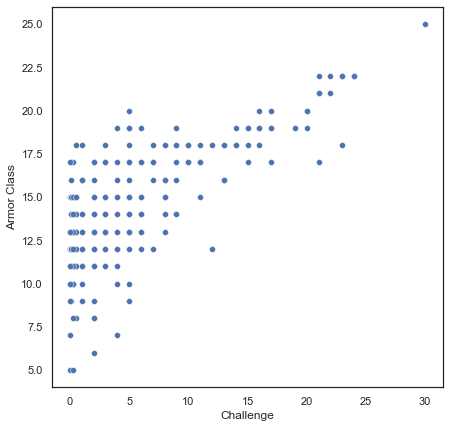

In [396]:
fig = plt.figure(figsize = (7,7));
ax = sns.scatterplot(monster_df["Challenge"], monster_df["Armor Class"]);

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


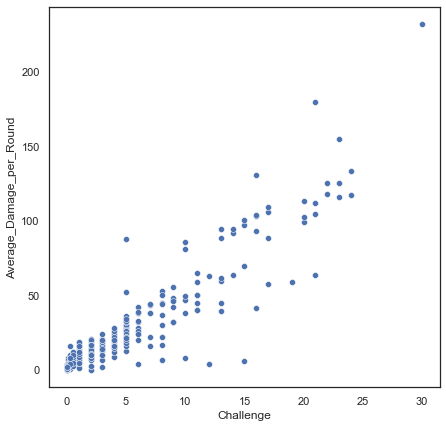

In [397]:
fig = plt.figure(figsize = (7,7));
ax = sns.scatterplot(monster_df["Challenge"], monster_df["Average_Damage_per_Round"])

Dexterity falls short again. It looks like a very low correlation. Same with Wisdom. 

### Resistences, Immunities

In [398]:
#dataframe
resistence_immunity_df = pd.melt(monster_df, id_vars = ['Challenge'],value_vars=[ 'Damage Resistances', 'Damage Immunities', 'Condition Immunities', 'Damage Vulnerabilities'])
resistence_immunity_df.columns = ['Challenge','Res_Immun', 'value']

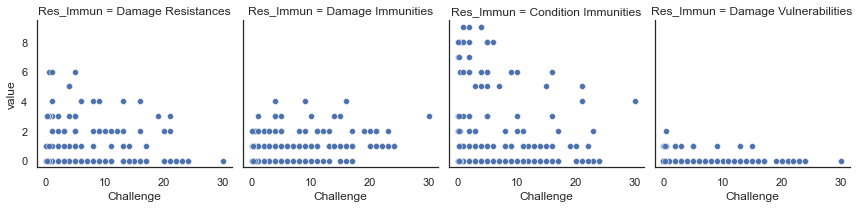

In [399]:
g = sns.FacetGrid(resistence_immunity_df, col="Res_Immun")
g.map_dataframe(sns.scatterplot, x="Challenge", y="value")

Unexpectedly high number of resistences and immunites for the lower CRs. I also expected more of a positive correlation for these

## Input Categories: Environment, Size, Monster Type, Alignment and Challenge Rating

In [400]:
monster_df.columns

Index(['Monster Name', 'Size', 'Type', 'Alignment', 'Traits', 'Reactions',
       'Armor Class', 'Hit Points', 'Speed', 'Challenge', 'Proficiency Bonus',
       'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA', 'Actions',
       'Legendary Actions', 'Environment', 'Attack_Bonus', 'Spell_Bonus',
       'Spell_Save_DC', 'WIS_SV', 'INT_SV', 'CHA_SV', 'STR_SV', 'DEX_SV',
       'CON_SV', 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill',
       'Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban',
       'Average_Damage_per_Round', 'Damage Resistances', 'Damage Immunities',
       'Condition Immunities', 'Damage Vulnerabilities', 'Spellcaster',
       'Magic Resistance', 'Legendary Resistance', 'Regeneration',
       'Undead Fortitude', 'Pack Tactics', 'Damage Transfer',
       'Angelic Weapons', 'Charge'],
      dtype='object')

### Distribution of Inputs for Dataset

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


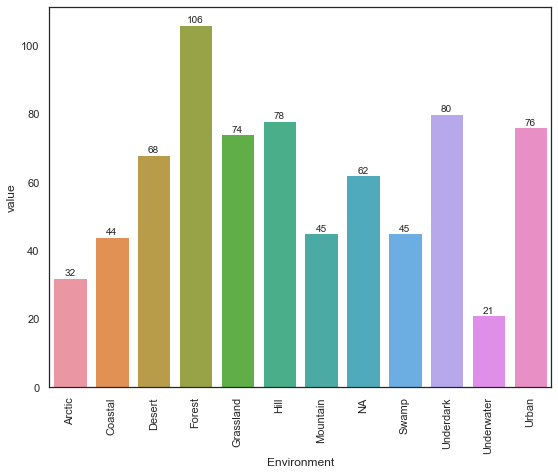

In [401]:
# Create a dataframe for environmental feature and count them
environment_df = pd.melt(monster_df, value_vars=[ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'])
environment_df.columns = ['Environment', 'value']
environment_df  = environment_df.groupby('Environment').sum().reset_index()

fig = plt.figure(figsize = (9,7));
ax = sns.barplot(environment_df["Environment"], environment_df['value'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for i in ax.containers:
    ax.bar_label(i,)

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


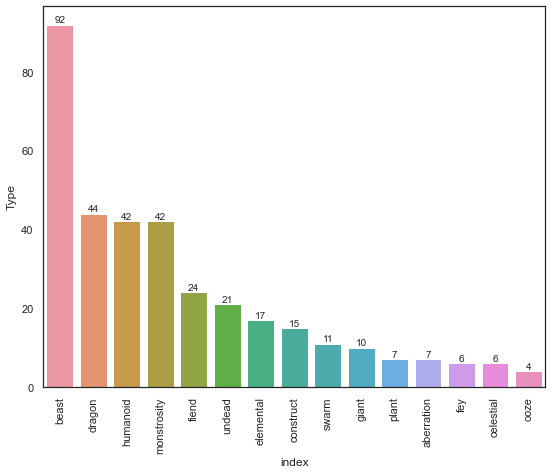

In [402]:
type_df = monster_df["Type"].value_counts().reset_index()

fig = plt.figure(figsize = (9,7));
ax = sns.barplot(type_df["index"], type_df['Type'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for i in ax.containers:
    ax.bar_label(i,)

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


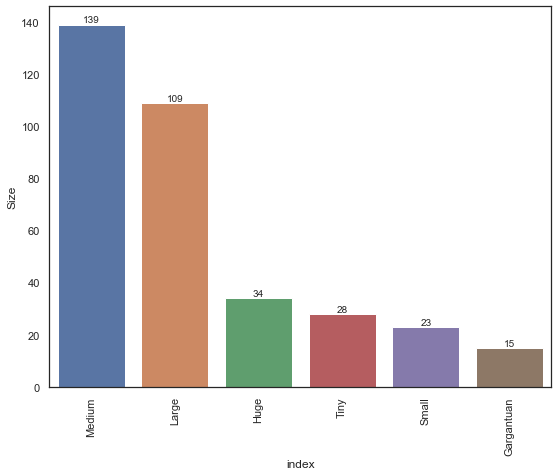

In [403]:
size_df = monster_df["Size"].value_counts().reset_index()

fig = plt.figure(figsize = (9,7));
ax = sns.barplot(size_df["index"], size_df['Size'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for i in ax.containers:
    ax.bar_label(i,)

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


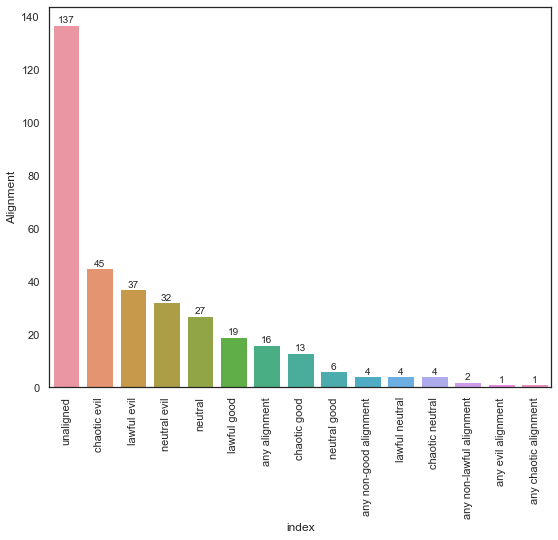

In [404]:
alignment_df = monster_df["Alignment"].value_counts().reset_index()

fig = plt.figure(figsize = (9,7));
ax = sns.barplot(alignment_df["index"], alignment_df['Alignment'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for i in ax.containers:
    ax.bar_label(i,)

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


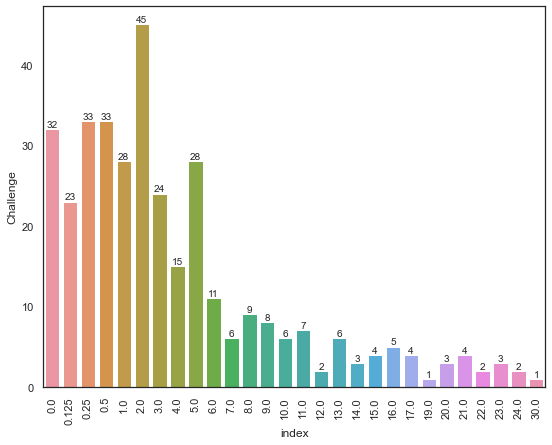

In [405]:
challenge_df = monster_df["Challenge"].value_counts().reset_index()

fig = plt.figure(figsize = (9,7));
ax = sns.barplot(challenge_df["index"], challenge_df['Challenge'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for i in ax.containers:
    ax.bar_label(i,)

### Input Categories vs. Stats How do they Compare?

#### Monster Type

In [406]:
#Stats dataframe
stats_box_df = pd.melt(monster_df, id_vars=['Type'], value_vars=[ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'])
stats_box_df.columns = ['Type','Stats', 'value']

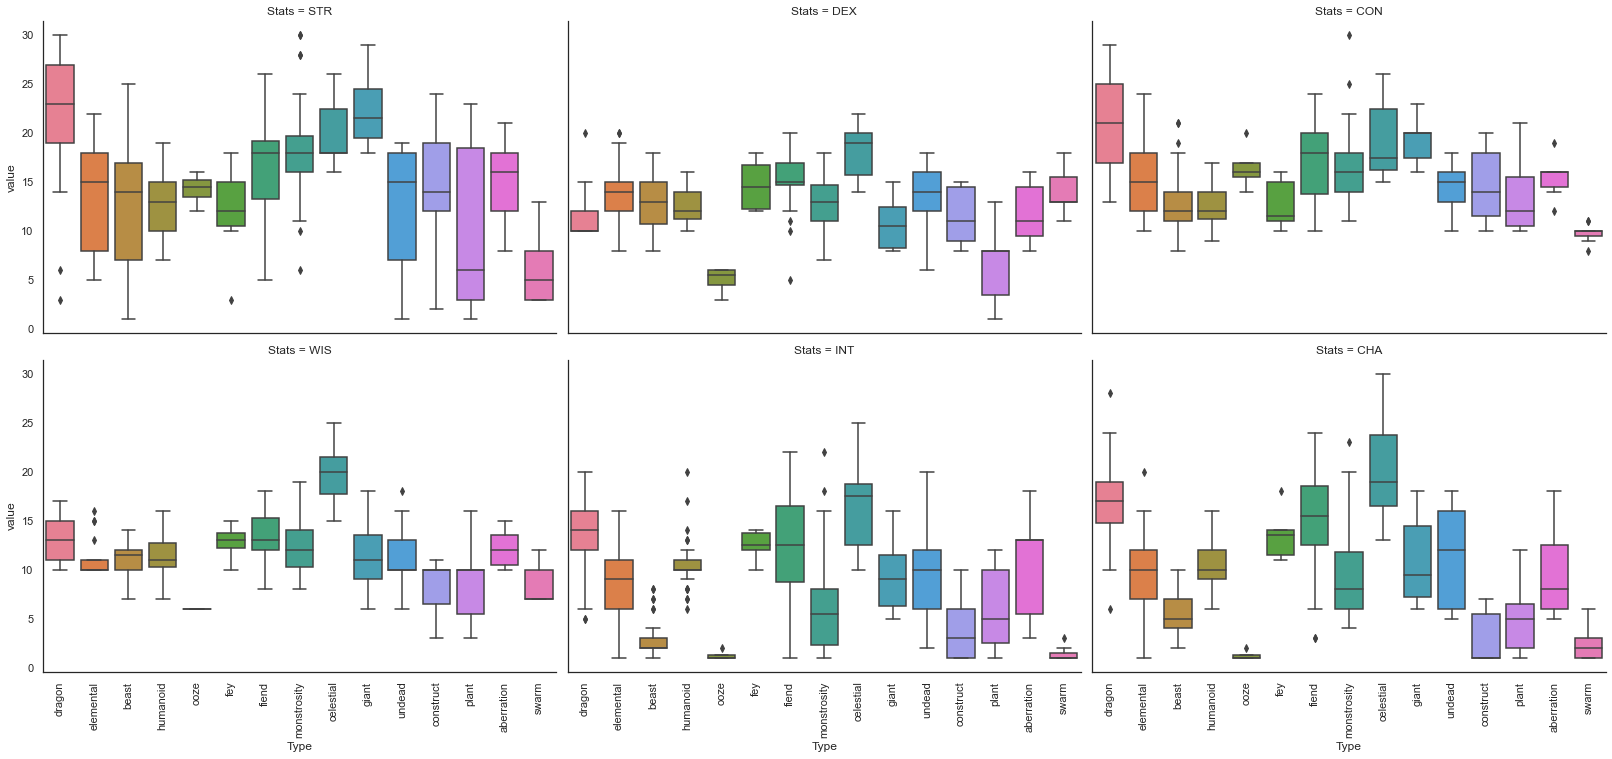

In [407]:
g = sns.FacetGrid(stats_box_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Type", palette = "husl")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


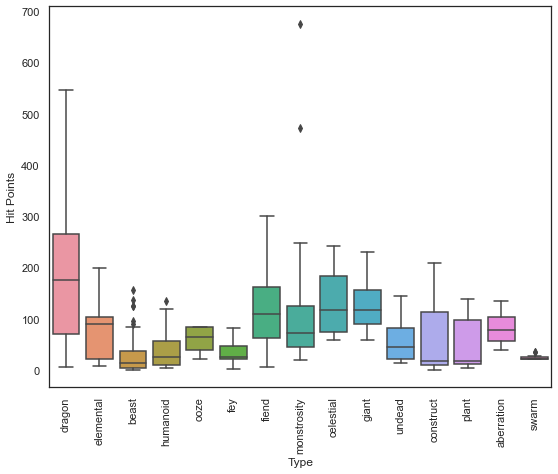

In [408]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Type"], monster_df["Hit Points"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


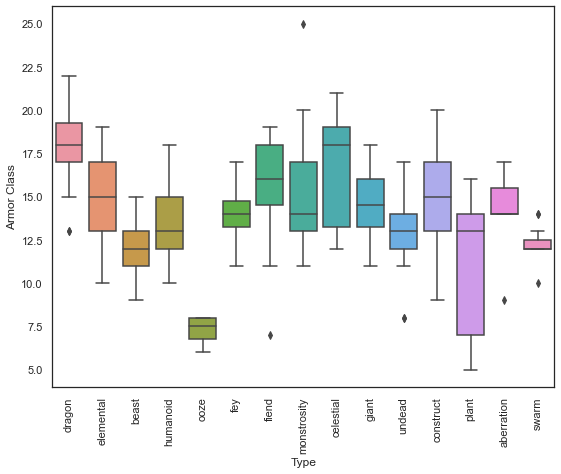

In [409]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Type"], monster_df["Armor Class"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
# Poor ooze

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


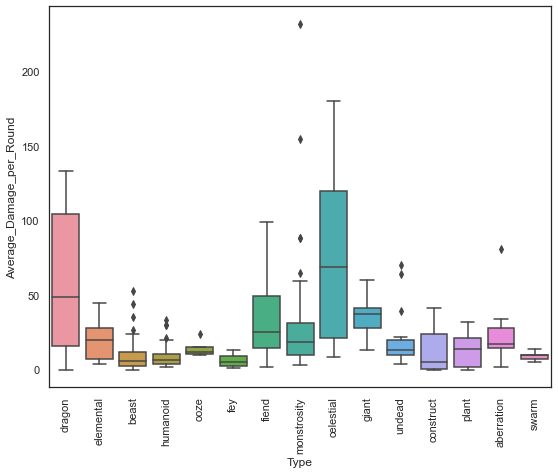

In [410]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Type"], monster_df["Average_Damage_per_Round"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
# Poor ooze

In [411]:
#saving_throw dataframe
type_saving_throw_df = pd.melt(monster_df, id_vars=['Type'], value_vars=[ 'STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV'])
type_saving_throw_df.columns = ['Type','Stats', 'value']

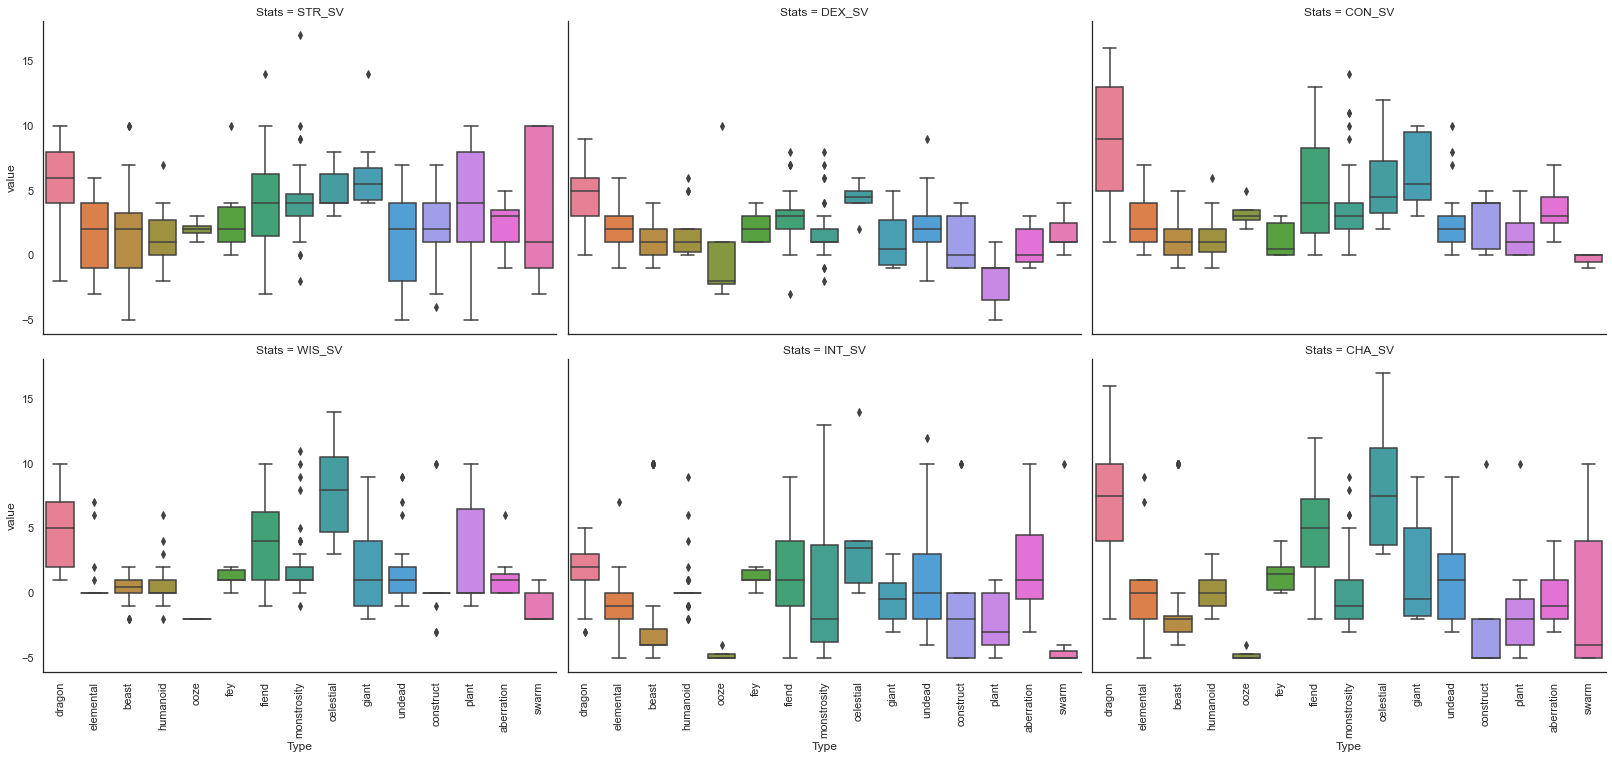

In [412]:
g = sns.FacetGrid(type_saving_throw_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Type", palette = "husl")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


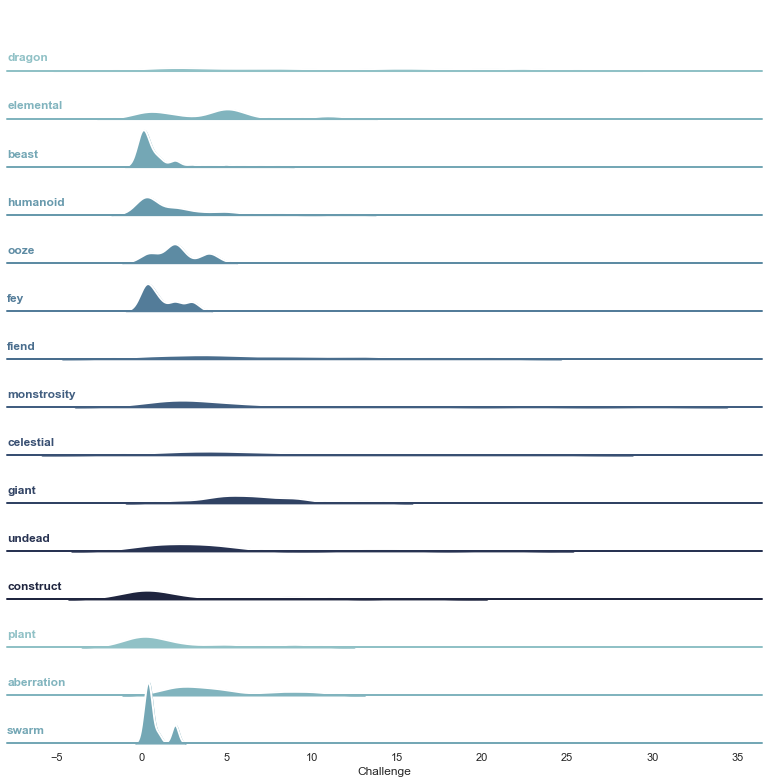

In [413]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(12, rot=-.25, light=.7)
g = sns.FacetGrid(monster_df, row="Type", hue="Type", aspect=15, height=.75, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Challenge",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Challenge", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Challenge")


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

#### Environment

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


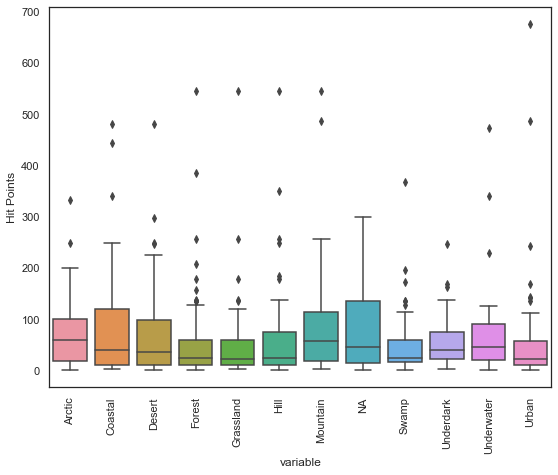

In [414]:
environment_HP_df = pd.melt(monster_df, value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'], id_vars = 'Hit Points')

# Filter out 0 environment values caused by binary encoding
environment_HP_df =environment_HP_df.loc[environment_HP_df["value"] == 1]

fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(environment_HP_df["variable"], environment_HP_df["Hit Points"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


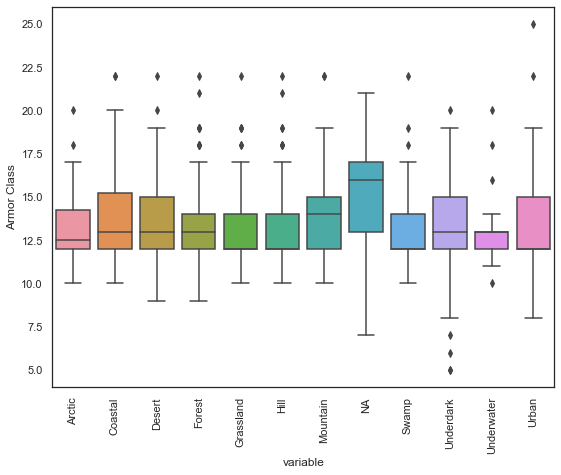

In [415]:
environment_armor_df = pd.melt(monster_df, value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'], id_vars = 'Armor Class')

environment_armor_df =environment_armor_df.loc[environment_armor_df["value"] == 1]

fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(environment_armor_df["variable"], environment_armor_df["Armor Class"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


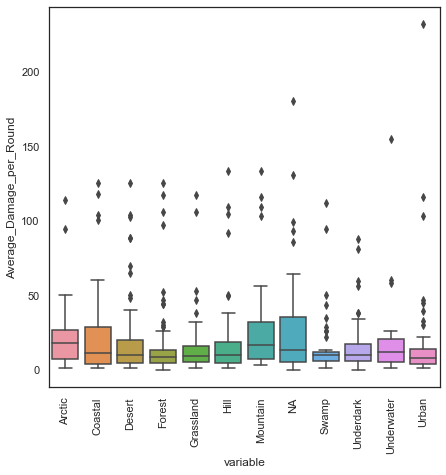

In [416]:
environment_damge_df = pd.melt(monster_df, value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'], id_vars = 'Average_Damage_per_Round')

environment_damge_df =environment_damge_df.loc[environment_damge_df["value"] == 1]

fig = plt.figure(figsize = (7,7));
ax = sns.boxplot(environment_damge_df["variable"], environment_damge_df["Average_Damage_per_Round"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

In [417]:
# Melt down Environments into a single columns with all stats
environment_stats_melt_df  = pd.melt(monster_df, id_vars=[ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'], value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'])
environment_stats_melt_df.columns = ['STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA','Environment', 'value']
# Filter out the 0 value environments that occur due to binary encoding
environment_stats_melt_df=environment_stats_melt_df[environment_stats_melt_df['value']== 1]

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\IPython\core\interactiveshell.py:3251: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


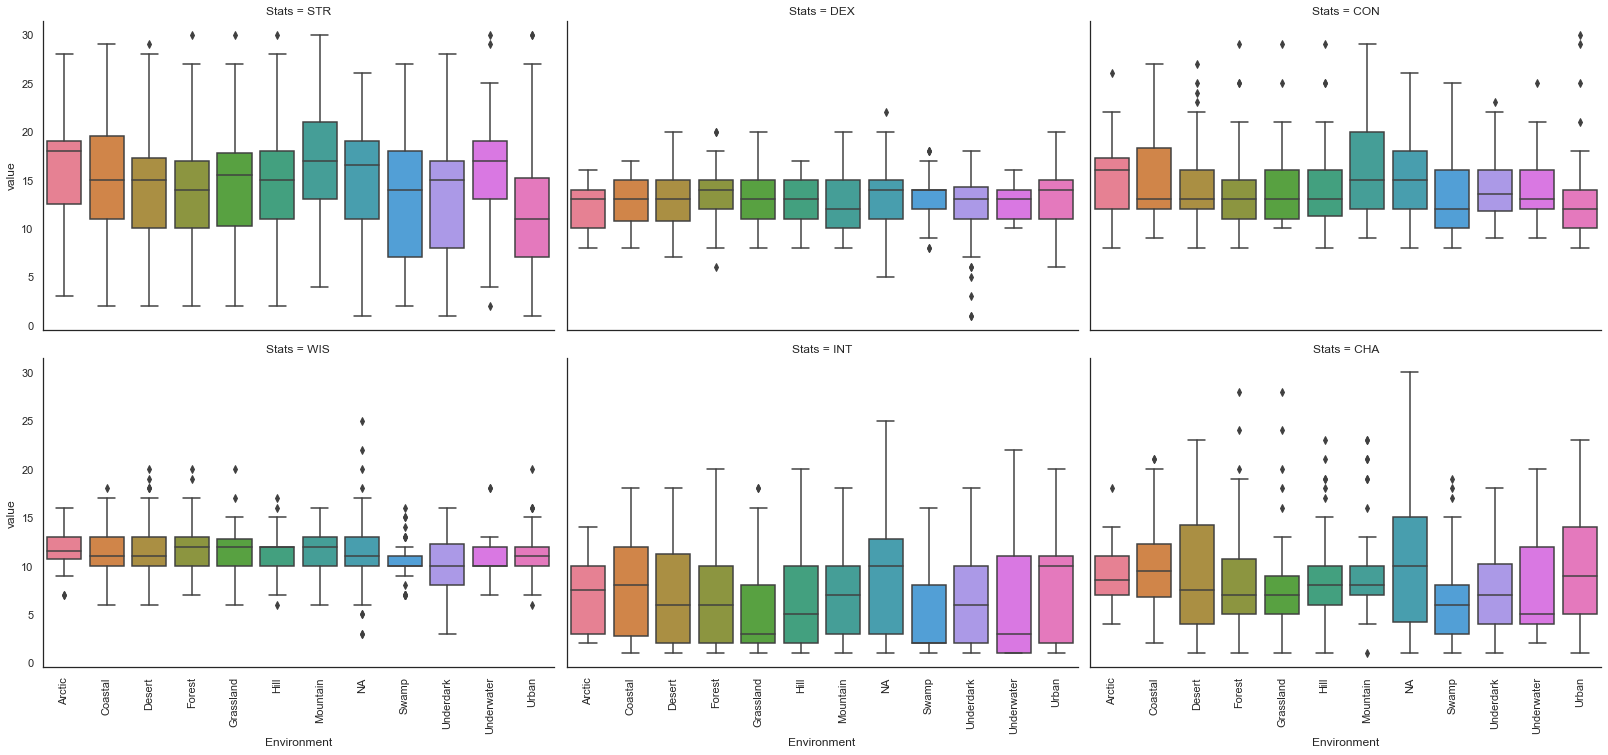

In [418]:
# Melt down stats into a pivot long format for Facet Graph
stats_environment_df = pd.melt(environment_stats_melt_df, id_vars=['Environment'], value_vars=[ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'])
stats_environment_df.columns = ['Environment','Stats', 'value']

g = sns.FacetGrid(stats_environment_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Environment", palette = "husl")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

In [419]:
# Melt down Environments into a single columns with all stats
environemt_saving_throw_df  = pd.melt(monster_df, id_vars=[ 'STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV'], value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'])
environemt_saving_throw_df.columns = ['STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV', 'Environment', 'value']
# Filter out the 0 value environments that occur due to binary encoding
environemt_saving_throw_df=environemt_saving_throw_df[environemt_saving_throw_df['value']== 1]

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\IPython\core\interactiveshell.py:3251: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


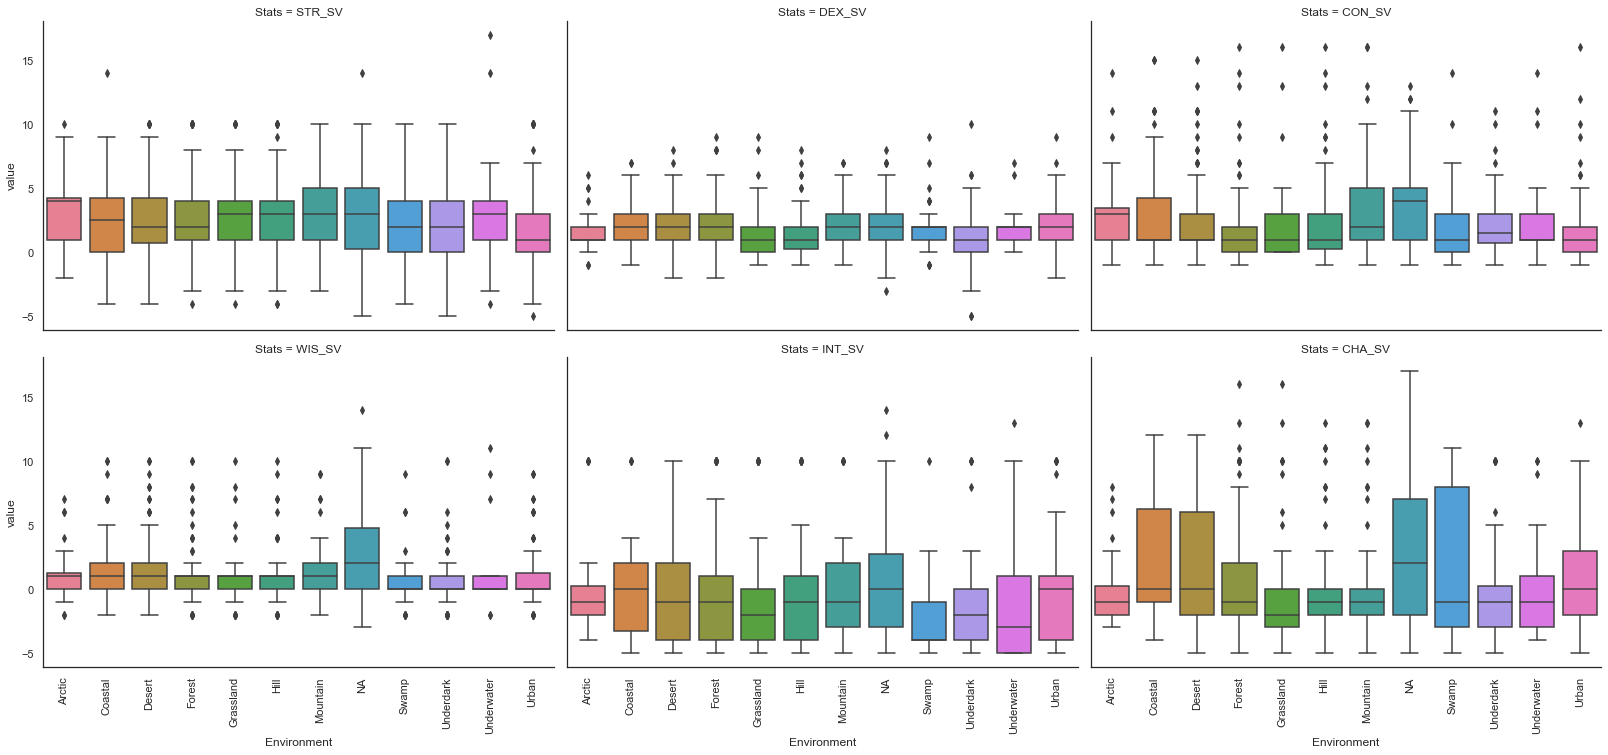

In [420]:
# Melt down stats into a pivot long format for Facet Graph
saving_throw_environment_df = pd.melt(environemt_saving_throw_df, id_vars=['Environment'], value_vars=[ 'STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV'])
saving_throw_environment_df.columns = ['Environment','Stats', 'value']

g = sns.FacetGrid(saving_throw_environment_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Environment", palette = "husl")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

In [421]:
#Create challenge rating and environmental dataframe
challenge_enviro = pd.melt(monster_df, value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'], id_vars = ['Challenge'])
challenge_enviro =challenge_enviro.loc[challenge_enviro["value"] == 1]
challenge_enviro.drop('value',axis=1,inplace=True)
challenge_enviro

Challenge variable
2        13.000   Arctic
9         0.125   Arctic
38        2.000   Arctic
57        2.000   Arctic
61       11.000   Arctic
...         ...      ...
4165      0.500    Urban
4169     30.000    Urban
4170      3.000    Urban
4172      0.250    Urban
4173      0.000    Urban

[731 rows x 2 columns]

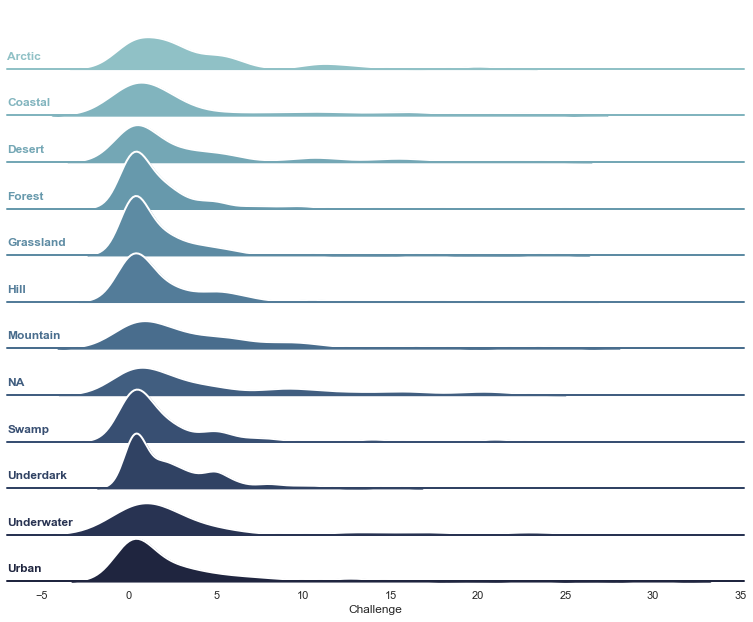

In [422]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(12, rot=-.25, light=.7)
g = sns.FacetGrid(challenge_enviro, row="variable", hue="variable", aspect=15, height=.75, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Challenge",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Challenge", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Challenge")


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)



#### Alignment

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


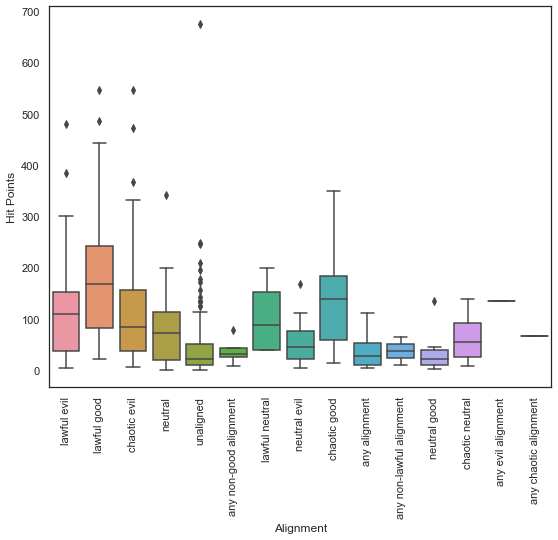

In [423]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Alignment"], monster_df["Hit Points"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


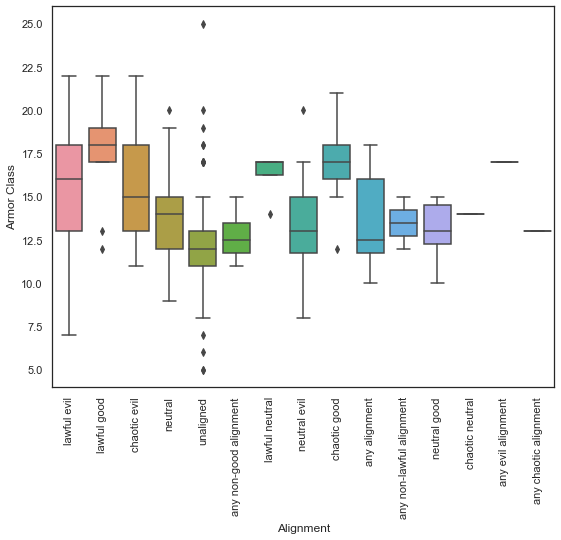

In [424]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Alignment"], monster_df["Armor Class"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

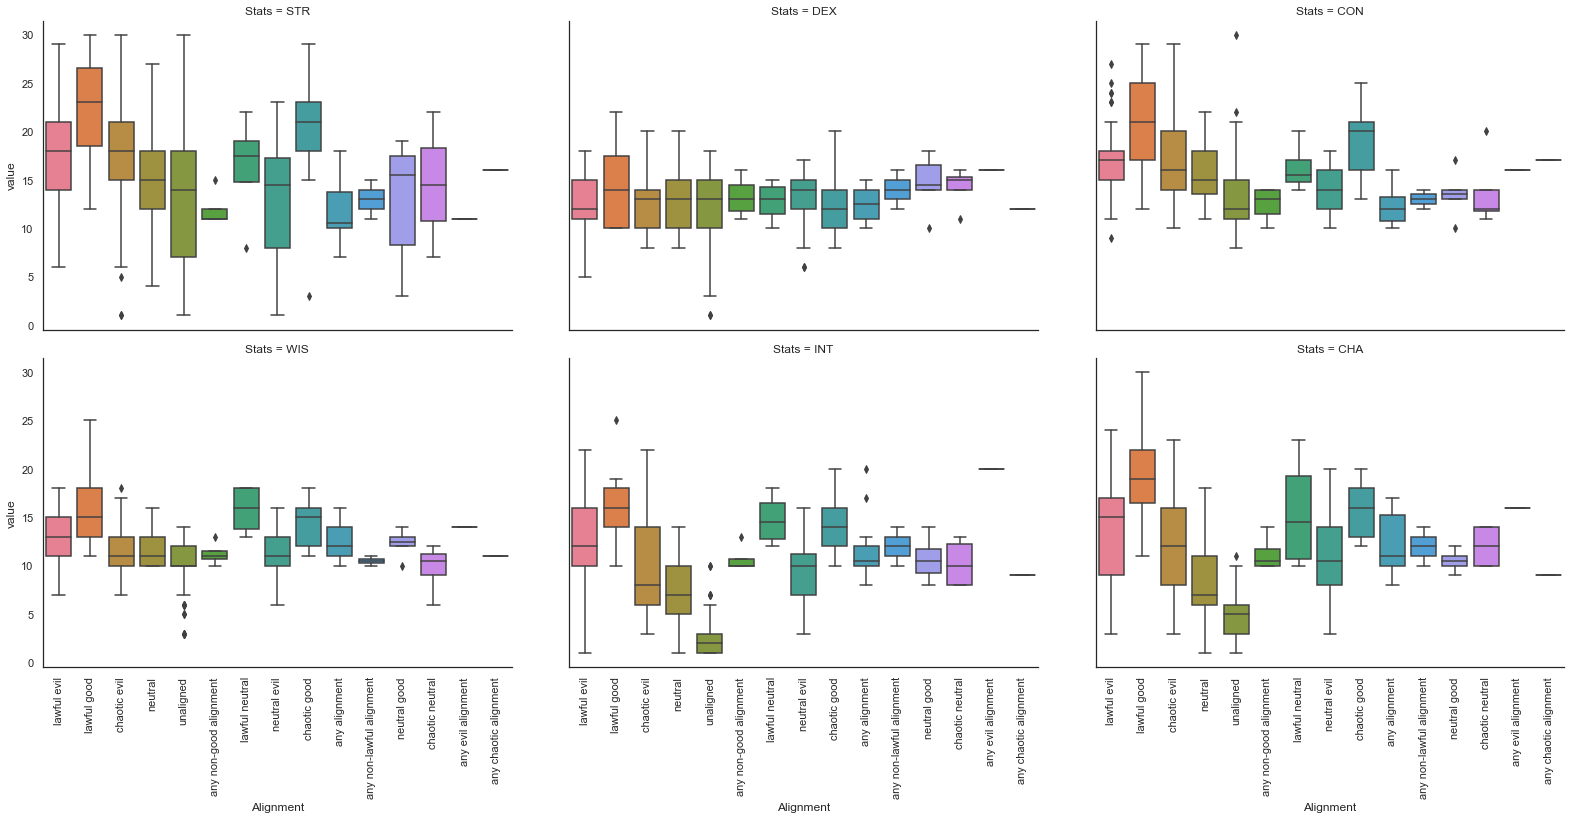

In [425]:
# Melt down stats into a pivot long format for Facet Graph
alignment_stats_df = pd.melt(monster_df, id_vars=['Alignment'], value_vars=[ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'])

alignment_stats_df.columns = ['Alignment','Stats', 'value']

g = sns.FacetGrid(alignment_stats_df, col="Stats", col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Alignment", palette = "husl")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

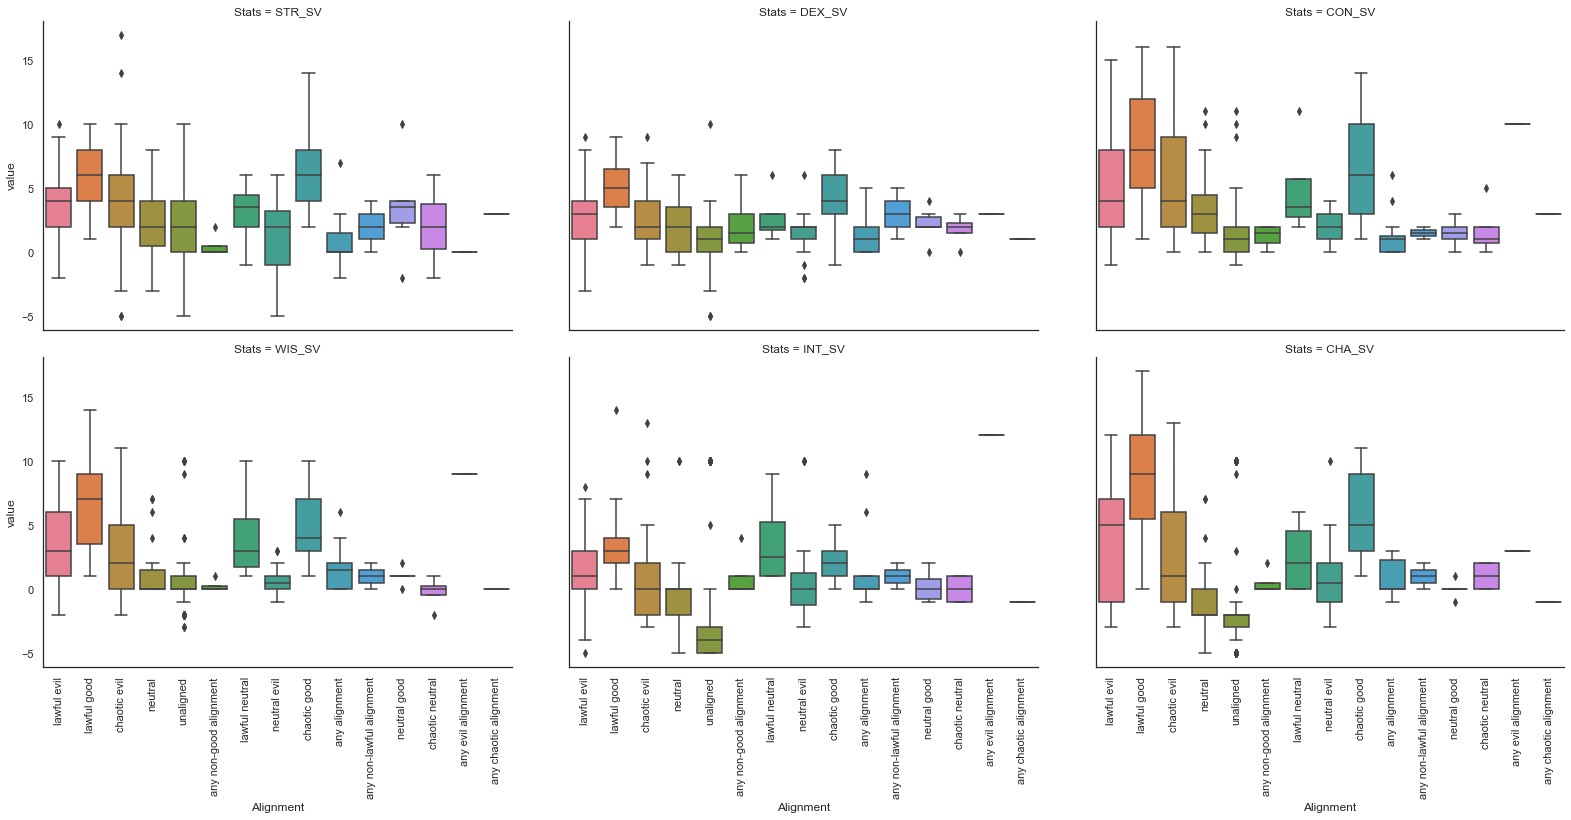

In [426]:
# Melt down saving throw into a pivot long format for Facet Graph
saving_throw_alignment_df = pd.melt(monster_df, id_vars=['Alignment'], value_vars=[ 'STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV'])
saving_throw_alignment_df.columns = ['Alignment','Stats', 'value']

g = sns.FacetGrid(saving_throw_alignment_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Alignment", palette = "husl")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

#### Size

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


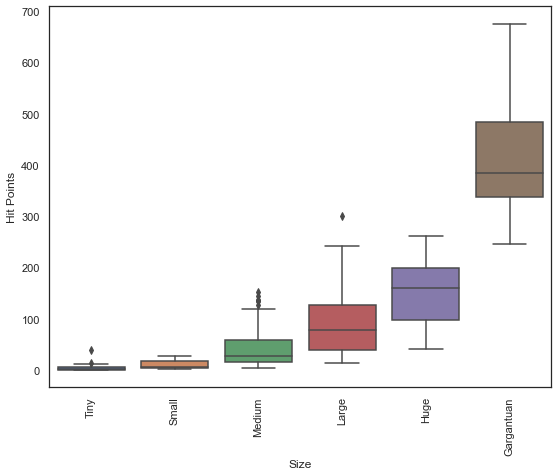

In [427]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Size"], monster_df["Hit Points"], order=['Tiny','Small','Medium','Large','Huge','Gargantuan'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


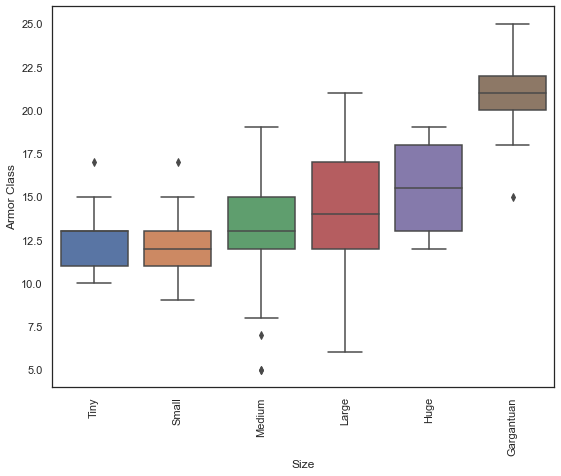

In [428]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Size"], monster_df["Armor Class"], order=['Tiny','Small','Medium','Large','Huge','Gargantuan'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


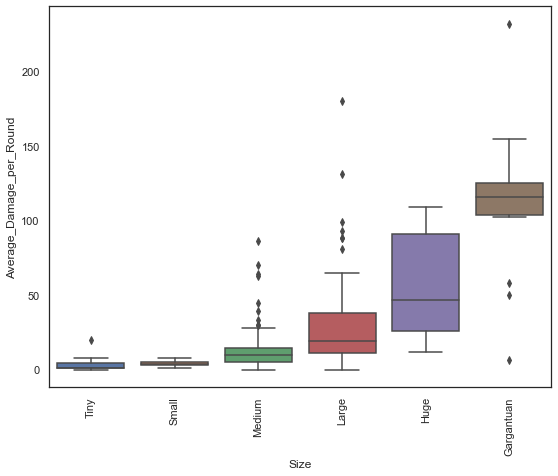

In [429]:
fig = plt.figure(figsize = (9,7));
ax = sns.boxplot(monster_df["Size"], monster_df["Average_Damage_per_Round"], order=['Tiny','Small','Medium','Large','Huge','Gargantuan'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

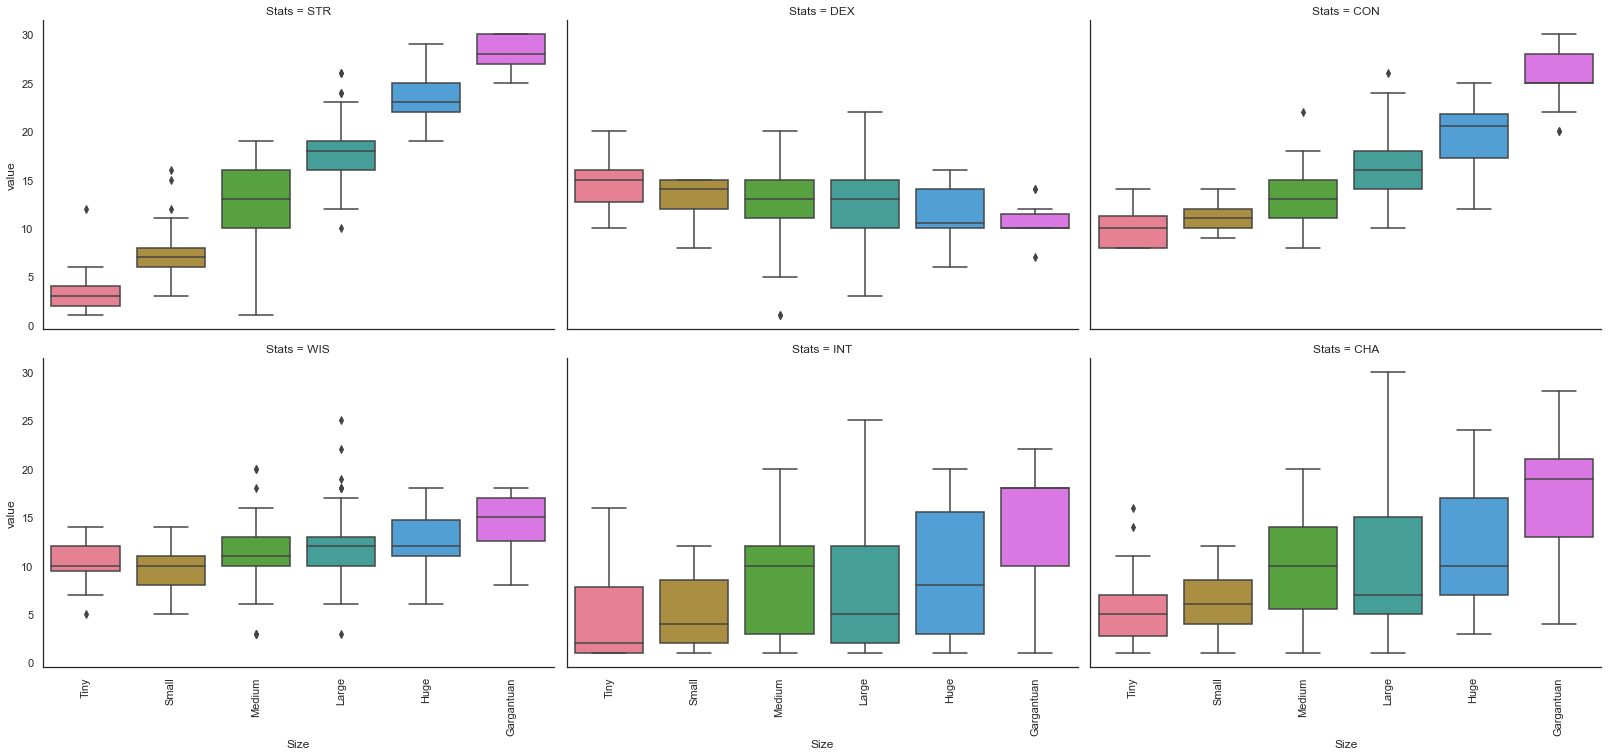

In [430]:
# Melt down stats into a pivot long format for Facet Graph
stats_size_df = pd.melt(monster_df, id_vars=['Size'], value_vars=[ 'STR', 'DEX', 'CON', 'WIS', 'INT', 'CHA'])
stats_size_df.columns = ['Size','Stats', 'value']

g = sns.FacetGrid(stats_size_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Size", palette = "husl", order=['Tiny','Small','Medium','Large','Huge','Gargantuan'])

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

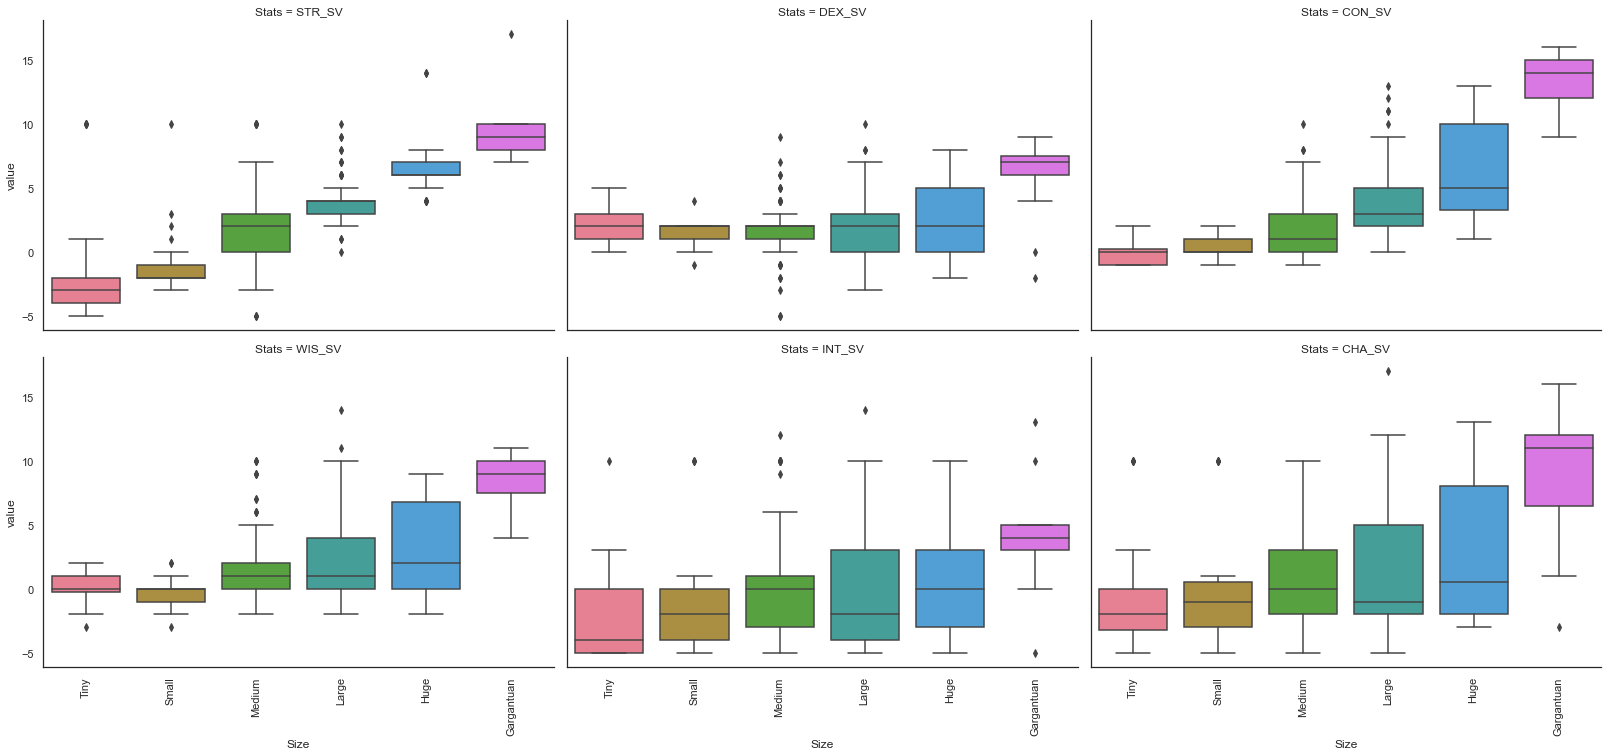

In [431]:
# Melt down saving throw into a pivot long format for Facet Graph
saving_throw_size_df = pd.melt(monster_df, id_vars=['Size'], value_vars=[ 'STR_SV', 'DEX_SV', 'CON_SV', 'WIS_SV', 'INT_SV', 'CHA_SV'])
saving_throw_size_df.columns = ['Size','Stats', 'value']

g = sns.FacetGrid(saving_throw_size_df, col="Stats",col_wrap = 3, height =5, 
                    aspect =1.5)
g.map_dataframe(sns.boxplot, y="value", x="Size", palette = "husl", order=['Tiny','Small','Medium','Large','Huge','Gargantuan'])

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

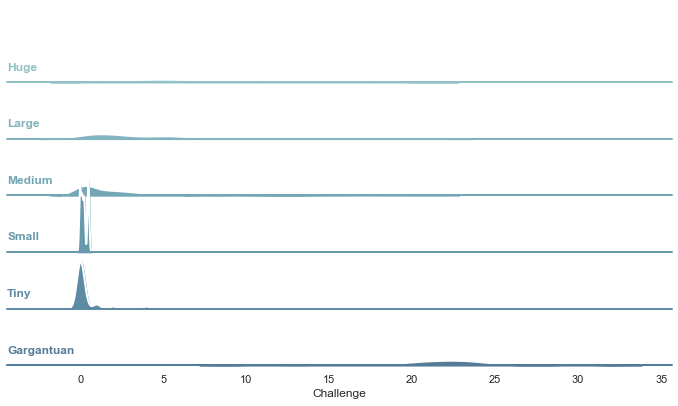

In [432]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(12, rot=-.25, light=.7)
g = sns.FacetGrid(monster_df, row="Size", hue="Size", aspect=10, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Challenge",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Challenge", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Challenge")


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

### Looking at Environment, Monster Type, and CR stat blocks
I want to use these for the model we will make as our inputs, so we need a better idea of what they look like when related to our stats

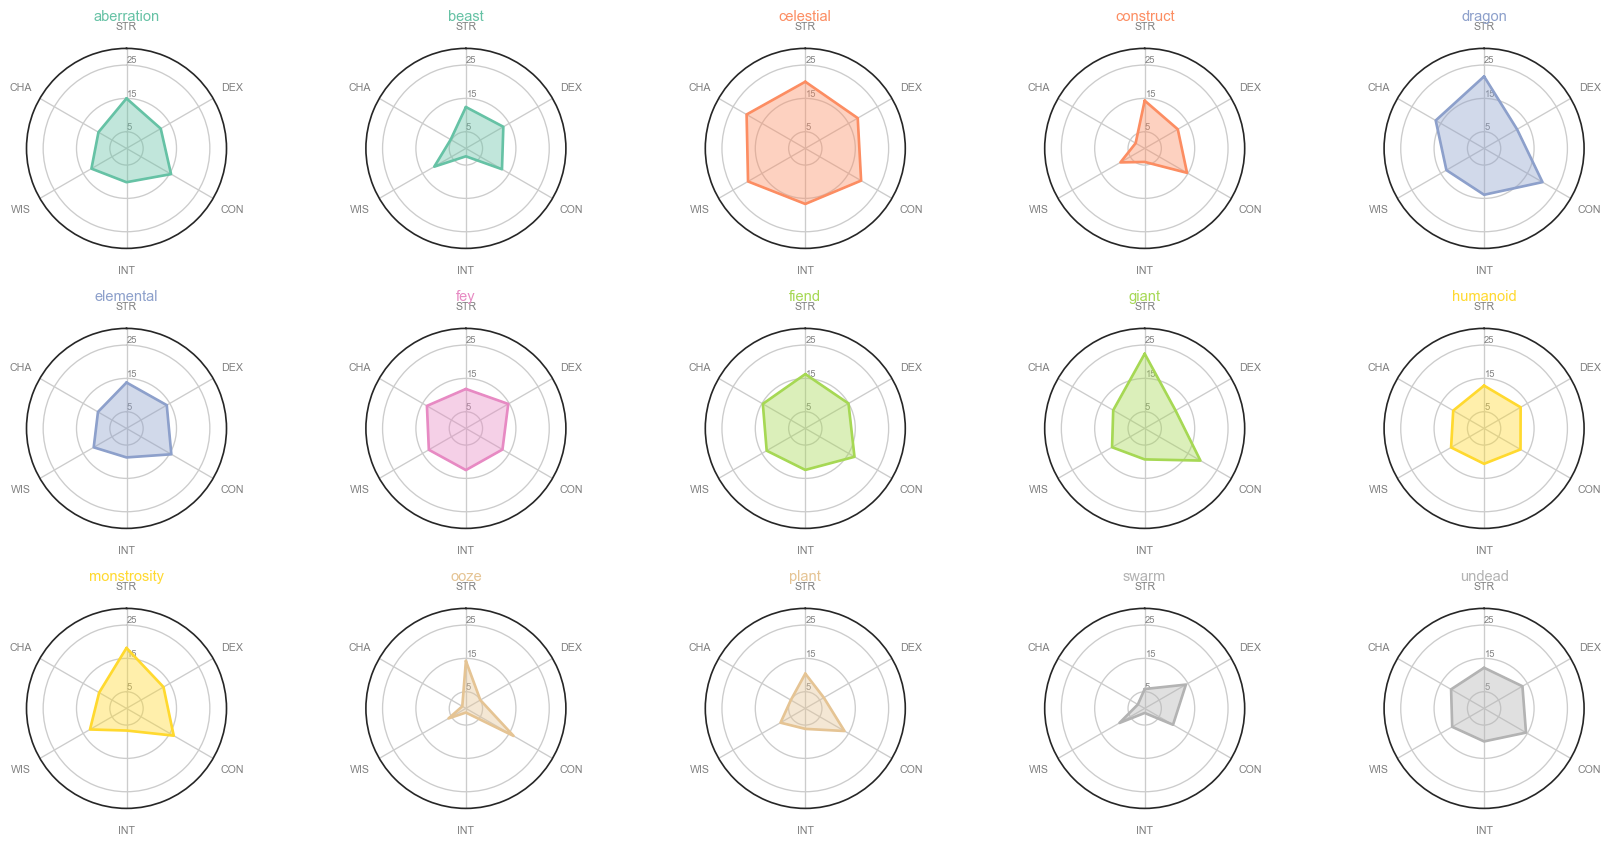

In [433]:
monster_stats = monster_df[['Type','STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA']]
monster_stats = monster_stats.groupby('Type').mean()
monster_stats = monster_stats.reset_index()

# Best way to see this is with as radar chart: adapted from python-graph-gallery

def make_spider(df, group, row, title, color):

    # Number of variables
    categories = list(df)[1:7]
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(6, 5, row+1, polar = True, )
    plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.9, 
                        top = 0.9, wspace = 0.4, hspace = 0.4)
    
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color = "grey", size = 8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([5,15,25], ["5", "15", "25"], color="grey", size = 7)
    plt.ylim(0,30)

    # Ind1
    values = df.loc[row].drop(labels = [group]).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth = 2, linestyle = 'solid')
    ax.fill(angles, values, color = color, alpha = 0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)
 
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi = 96
plt.figure(figsize = (2000/my_dpi, 2000/my_dpi), dpi = my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(monster_stats.index))

# Loop to plot
for row in range(0, len(monster_stats.index)):
    make_spider(df = monster_stats,  group = 'Type', 
                row = row, title = monster_stats['Type'][row], 
                color = my_palette(row))
    




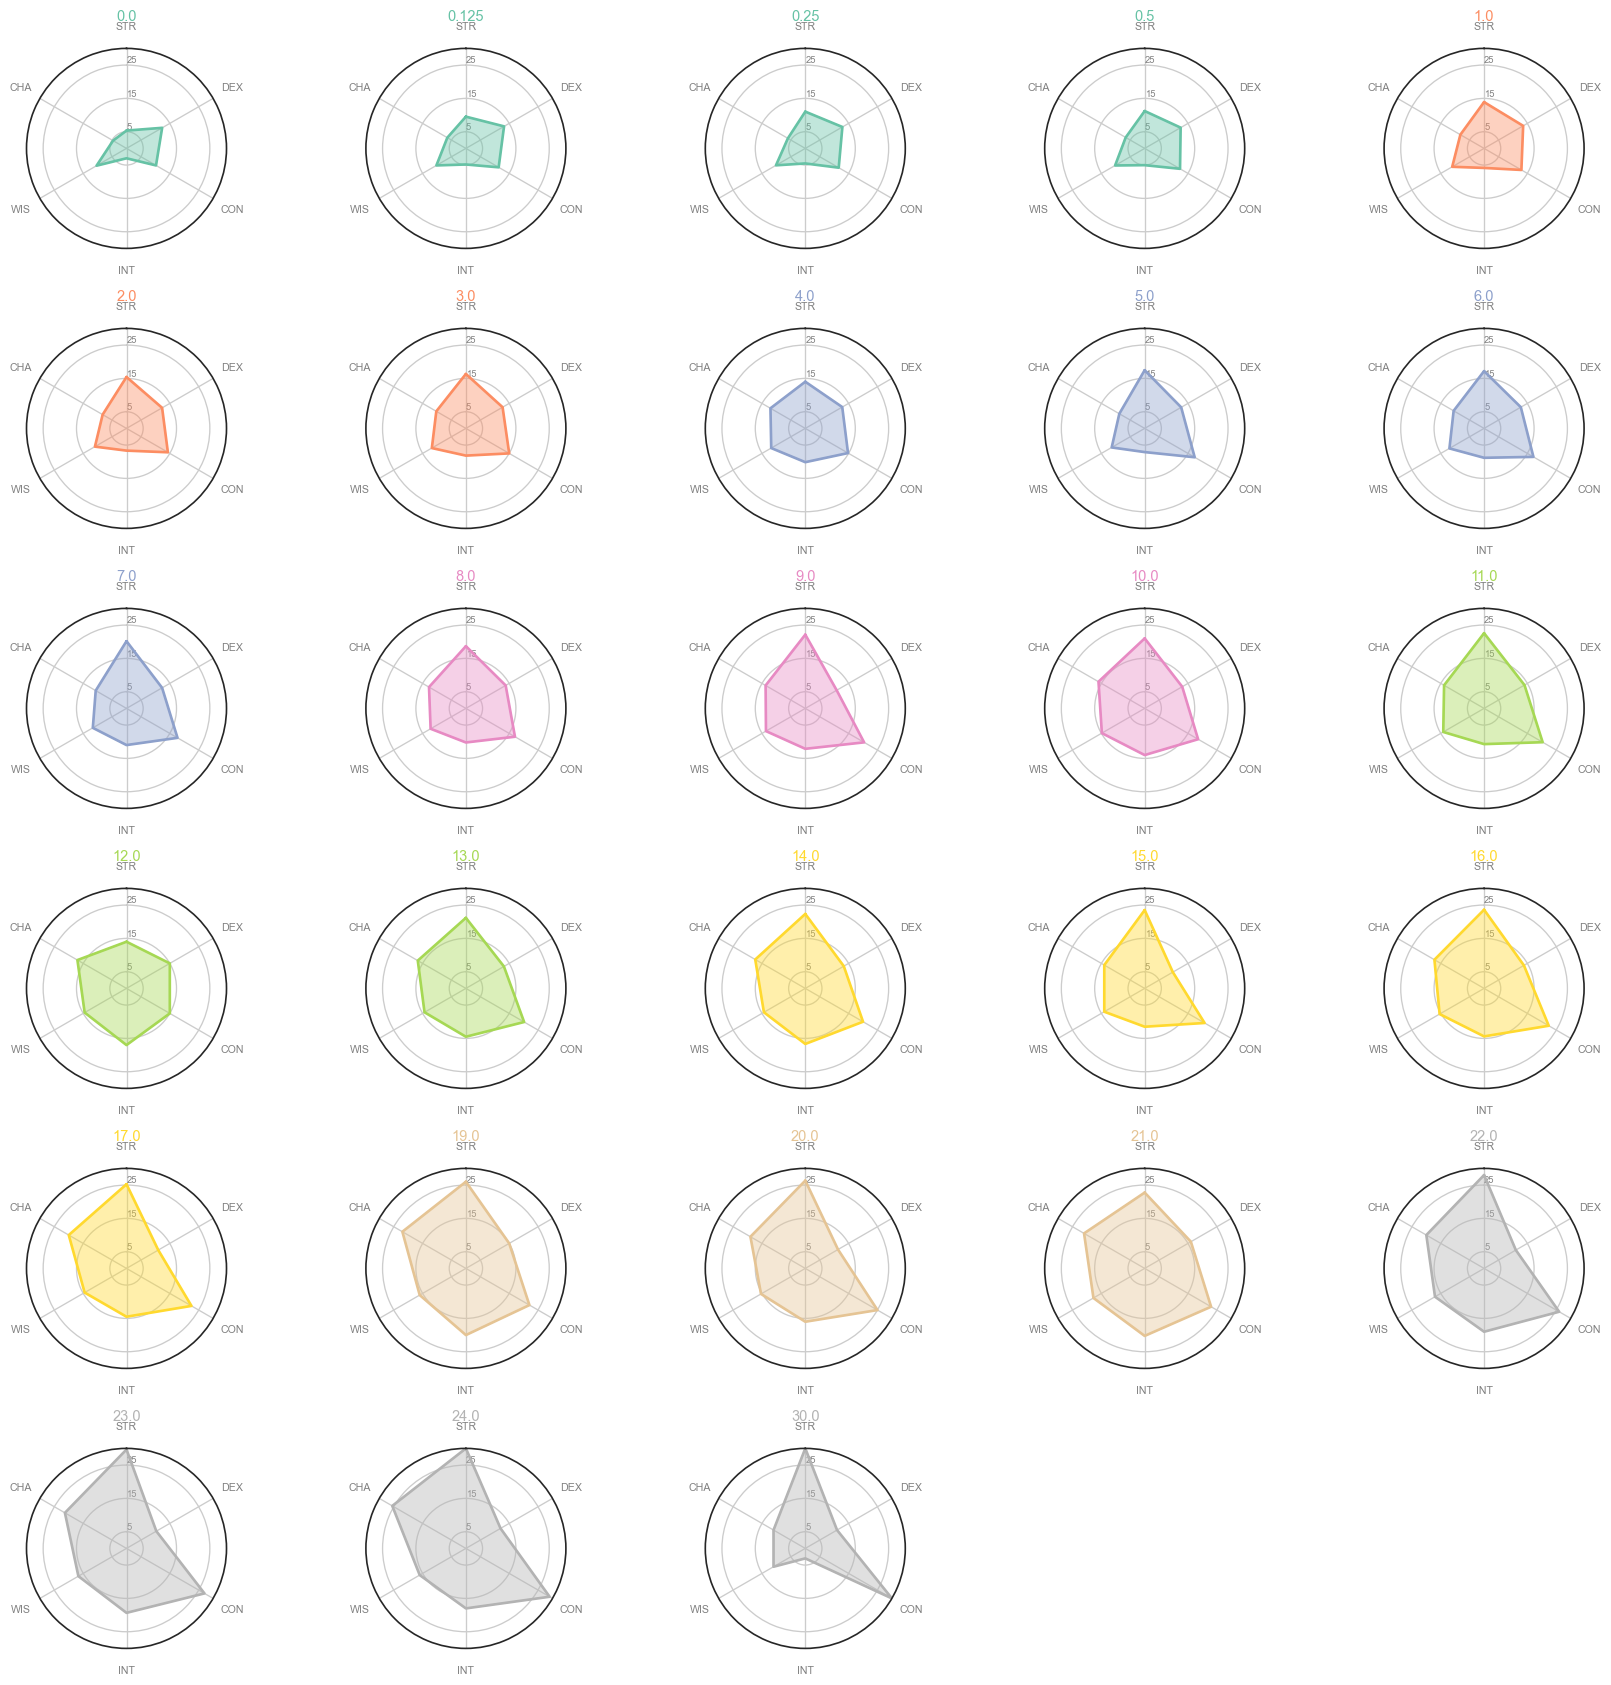

In [434]:
monster_challenge = monster_df[['Challenge', 'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA']]
monster_challenge = monster_challenge.groupby('Challenge').mean()
monster_challenge = monster_challenge.reset_index()

# initialize the figure
my_dpi = 96
plt.figure(figsize=(2000/my_dpi, 2000/my_dpi), dpi = my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(monster_challenge.index))

# Loop to plot
for row in range(0, len(monster_challenge.index)):
    make_spider(df = monster_challenge, group = 'Challenge', 
                row = row, title = monster_challenge['Challenge'][row], 
                color = my_palette(row))

In [435]:
# Create an environment & Stats dataframe for radar charts
stats_enviro = pd.melt(monster_df, value_vars= [ 'Arctic', 'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill','Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban'], id_vars = ['STR','DEX','CON','INT','WIS','CHA'])
stats_enviro =stats_enviro.loc[stats_enviro["value"] == 1]
stats_enviro.drop('value',axis=1,inplace=True)
stats_enviro.columns = ['STR','DEX','CON','INT','WIS','CHA','Environment']
stats_enviro.insert(0,'Environment',stats_enviro.pop('Environment'))
stats_enviro = stats_enviro.groupby('Environment').mean()
stats_enviro = stats_enviro.reset_index()

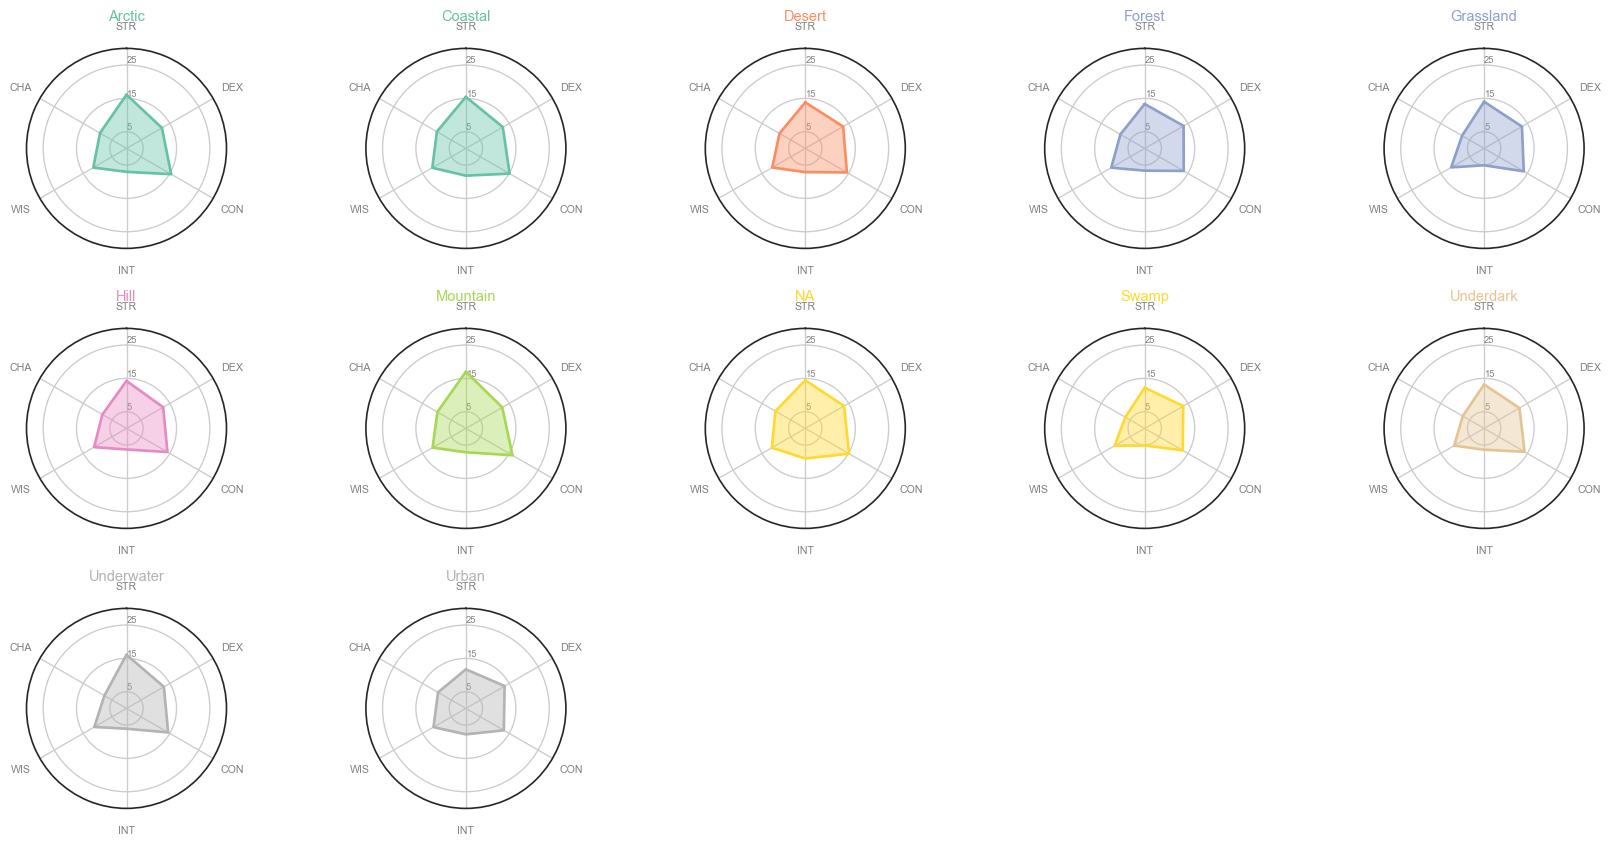

In [436]:
# Initialize the figure
my_dpi = 96
plt.figure(figsize = (2000/my_dpi, 2000/my_dpi), dpi = my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(stats_enviro.index))

# Loop to plot
for row in range(0, len(stats_enviro.index)):
    make_spider(df = stats_enviro, group = 'Environment', 
                row = row, title = stats_enviro['Environment'][row], 
                color = my_palette(row))

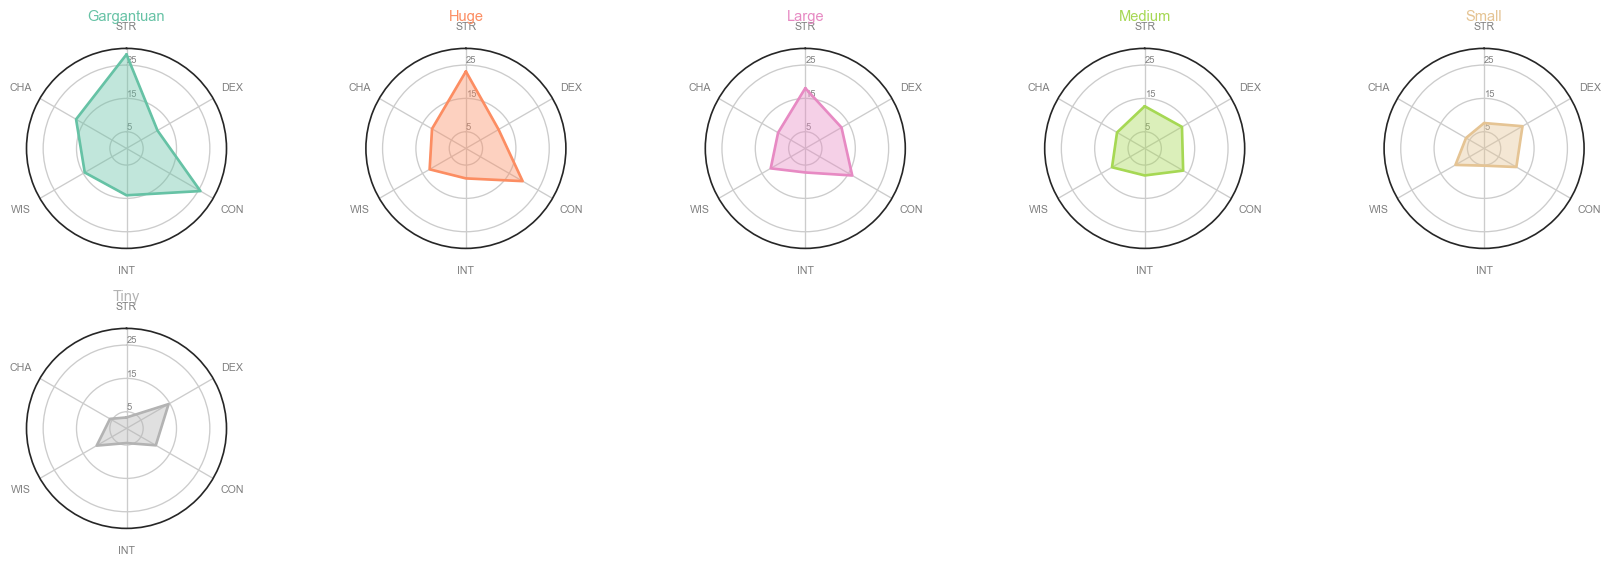

In [437]:
monster_Size = monster_df[['Size', 'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA']]
monster_Size = monster_Size.groupby('Size').mean()
monster_Size = monster_Size.reset_index()

# initialize the figure
my_dpi = 96
plt.figure(figsize=(2000/my_dpi, 2000/my_dpi), dpi = my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(monster_Size.index))

# Loop to plot
for row in range(0, len(monster_Size.index)):
    make_spider(df = monster_Size, group = 'Size', 
                row = row, title = monster_Size['Size'][row], 
                color = my_palette(row))

## More Numeric Only Comparisons

### Dropping Columns not needed for analysis

In [439]:
monster_df_wordless = monster_df.drop(columns = {'Environment','Actions','Speed'},axis=1)

### Encoding phrases, removing text and NaN for modeling

In [440]:
for indx, value in enumerate(monster_df_wordless['Legendary Actions']):
    if 'NA' in value:
        monster_df_wordless.loc[indx,'Legendary Actions'] = 0
    else:
        monster_df_wordless.loc[indx,'Legendary Actions'] = 1

In [441]:
for indx, value in enumerate(monster_df_wordless['Reactions']):
    if 'NA' in value:
        monster_df_wordless.loc[indx,'Reactions'] = 0
    else:
        monster_df_wordless.loc[indx,'Reactions'] = 1

In [442]:
for indx, value in enumerate(monster_df_wordless['Traits']):
    if 'nan' in value:
        monster_df_wordless.loc[indx,'Traits'] = 0
    else:
        monster_df_wordless.loc[indx,'Traits'] = 1

In [443]:
sns.pairplot(monster_df_wordless, vars=['Hit Points', 'Armor Class', 'STR','DEX','CON','INT','WIS','CHA','STR_SV','DEX_SV','CON_SV','INT_SV','WIS_SV','CHA_SV'],hue='Type',size=2.5)

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


In [ ]:
monster_df_wordless.describe().transpose()

count       mean        std  min    25%   50%  \
Armor Class               348.0  13.985632   3.155403  5.0  12.00  13.0   
Hit Points                348.0  78.399425  96.670352  1.0  17.00  45.0   
Challenge                 348.0   4.346624   5.711322  0.0   0.25   2.0   
Proficiency Bonus         348.0   2.712644   1.296486  2.0   2.00   2.0   
STR                       348.0  14.951149   6.705018  1.0  11.00  16.0   
DEX                       348.0  12.706897   3.078279  1.0  10.00  13.0   
CON                       348.0  14.991379   4.385913  8.0  12.00  14.0   
INT                       348.0   7.683908   5.673953  1.0   2.00   7.0   
WIS                       348.0  11.606322   2.896418  3.0  10.00  11.5   
CHA                       348.0   9.548851   5.780861  1.0   5.00   8.0   
Attack_Bonus              348.0   5.916667   3.425865  0.0   4.00   5.0   
Spell_Bonus               348.0   0.356322   1.635182  0.0   0.00   0.0   
Spell_Save_DC             348.0   1.500000   4.610163  0.0   0.00   0.0   
WIS_SV                    348.0   1.813218   3.052310 -3.0   0.00   1.0   
INT_SV                    348.0   0.051724   4.464741 -5.0  -4.00   0.0   
CHA_SV                    348.0   1.244253   4.827347 -5.0  -2.00   0.0   
STR_SV                    348.0   2.847701   3.634183 -5.0   0.75   3.0   
DEX_SV                    348.0   1.959770   2.306136 -5.0   0.00   2.0   
CON_SV                    348.0   3.183908   3.707703 -1.0   1.00   2.0   
Arctic                    348.0   0.091954   0.289377  0.0   0.00   0.0   
Coastal                   348.0   0.126437   0.332820  0.0   0.00   0.0   
Desert                    348.0   0.195402   0.397081  0.0   0.00   0.0   
Forest                    348.0   0.304598   0.460900  0.0   0.00   0.0   
Grassland                 348.0   0.212644   0.409767  0.0   0.00   0.0   
Hill                      348.0   0.224138   0.417614  0.0   0.00   0.0   
Mountain                  348.0   0.129310   0.336026  0.0   0.00   0.0   
NA                        348.0   0.178161   0.383199  0.0   0.00   0.0   
Swamp                     348.0   0.129310   0.336026  0.0   0.00   0.0   
Underdark                 348.0   0.229885   0.421365  0.0   0.00   0.0   
Underwater                348.0   0.060345   0.238467  0.0   0.00   0.0   
Urban                     348.0   0.218391   0.413749  0.0   0.00   0.0   
Average_Damage_per_Round  348.0  24.298851  32.164982  0.0   5.00  12.0   
Damage Resistances        348.0   0.525862   1.181958  0.0   0.00   0.0   
Damage Immunities         348.0   0.574713   0.836931  0.0   0.00   0.0   
Condition Immunities      348.0   1.163793   2.372795  0.0   0.00   0.0   
Damage Vulnerabilities    348.0   0.048851   0.228827  0.0   0.00   0.0   
Spellcaster               348.0   0.112069   0.315905  0.0   0.00   0.0   
Magic Resistance          348.0   0.100575   0.301198  0.0   0.00   0.0   
Legendary Resistance      348.0   0.066092   0.248800  0.0   0.00   0.0   
Regeneration              348.0   0.017241   0.130357  0.0   0.00   0.0   
Undead Fortitude          348.0   0.005747   0.075700  0.0   0.00   0.0   
Pack Tactics              348.0   0.051724   0.221788  0.0   0.00   0.0   
Damage Transfer           348.0   0.005747   0.075700  0.0   0.00   0.0   
Angelic Weapons           348.0   0.008621   0.092580  0.0   0.00   0.0   
Charge                    348.0   0.051724   0.221788  0.0   0.00   0.0   

                             75%    max  
Armor Class                16.00   25.0  
Hit Points                110.00  676.0  
Challenge                   5.25   30.0  
Proficiency Bonus           3.00    9.0  
STR                        19.00   30.0  
DEX                        15.00   22.0  
CON                        17.00   30.0  
INT                        12.00   25.0  
WIS                        13.00   25.0  
CHA                        14.00   30.0  
Attack_Bonus                7.00   19.0  
Spell_Bonus                 0.00   12.0  
Spell_Save_DC               0

### Encoding the Categorical Variables   

In [ ]:
# Type -nominal
# Size -ordinal
# Alignment -nominal
monster_df_wordless[['Traits','Legendary Actions','Reactions']] = monster_df_wordless[['Traits','Legendary Actions','Reactions']].apply(pd.to_numeric)

In [ ]:
monster_df_wordless.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Monster Name              348 non-null    object 
 1   Size                      348 non-null    object 
 2   Type                      348 non-null    object 
 3   Alignment                 348 non-null    object 
 4   Traits                    348 non-null    int64  
 5   Reactions                 348 non-null    int64  
 6   Armor Class               348 non-null    int64  
 7   Hit Points                348 non-null    int64  
 8   Challenge                 348 non-null    float64
 9   Proficiency Bonus         348 non-null    int64  
 10  STR                       348 non-null    int64  
 11  DEX                       348 non-null    int64  
 12  CON                       348 non-null    int64  
 13  INT                       348 non-null    int64  
 14  WIS       

In [ ]:
# Ordinal encoding
size_dict = {'Tiny':1,'Small':2,'Medium':3,'Large':4,'Huge':5,'Gargantuan':6}
monster_df_wordless['size_ordinal'] = monster_df_wordless.Size.map(size_dict)

In [ ]:
# One-hot encoding for Type and Alignment
ohe = OneHotEncoder(sparse=False)
result = ohe.fit_transform(monster_df_wordless[['Type']])
data_type = pd.DataFrame(result,columns=list(ohe.categories_[0]))

In [ ]:
result = ohe.fit_transform(monster_df_wordless[['Alignment']])
data_alignment = pd.DataFrame(ohe.fit_transform(monster_df_wordless[['Alignment']]),columns=list(ohe.categories_[0]))

In [ ]:
monster_df_wordless=pd.concat([monster_df_wordless,data_type],axis=1)
monster_df_wordless=pd.concat([monster_df_wordless,data_alignment],axis=1)


In [ ]:
# Create a stat column for total of all stats
monster_df_wordless['total_stats']= monster_df_wordless['STR']+monster_df_wordless['DEX']+monster_df_wordless['CON']+monster_df_wordless['WIS']+monster_df_wordless['INT']+monster_df_wordless['CHA']

In [ ]:
monster_df_wordless[['Monster Name','STR','DEX','CON','WIS','INT','CHA','total_stats']]

Monster Name  STR  DEX  CON  WIS  INT  CHA  total_stats
0     Adult Green Dragon   23   12   21   15   18   17          106
1    Adult Silver Dragon   27   10   25   13   16   21          112
2     Adult White Dragon   22   10   22   12    8   12           86
3          Air Elemental   14   20   14   10    6    6           70
4                    Ape   16   14   14   12    6    7           69
..                   ...  ...  ...  ...  ...  ...  ...          ...
343               Wyvern   19   10   16   12    5    6           68
344               Zombie   13    6   16    6    3    5           49
345             Commoner   10   10   10   10   10   10           60
346            Giant Owl   13   15   12   13    8   10           71
347             Glabrezu   20   15   21   17   19   16          108

[348 rows x 8 columns]

### Heatmap for all numeric categories

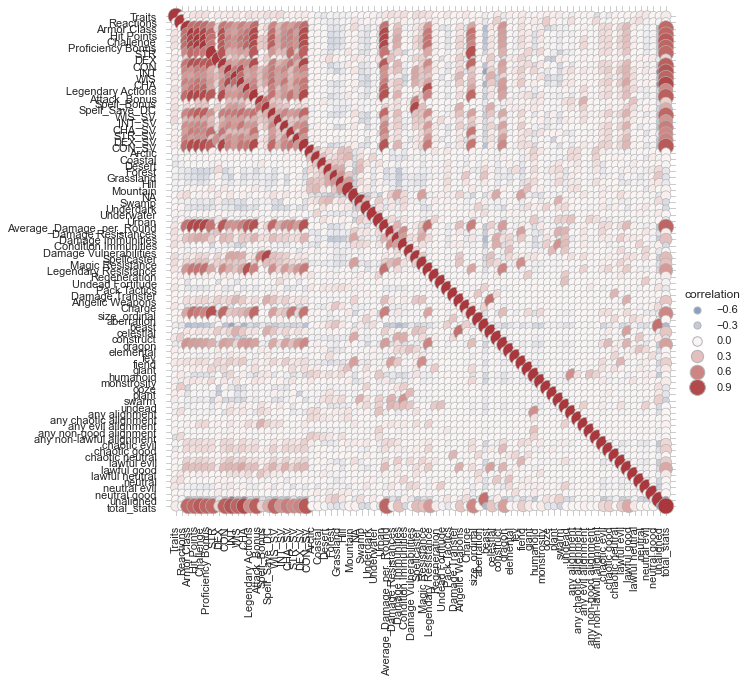

In [ ]:
sns.set_theme(style="whitegrid")


used_columns = monster_df_wordless.columns
                                    
df = monster_df_wordless.loc[:, used_columns]

# Compute a correlation matrix and convert to long-form
corr_mat = df.corr().stack().reset_index(name="correlation")

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


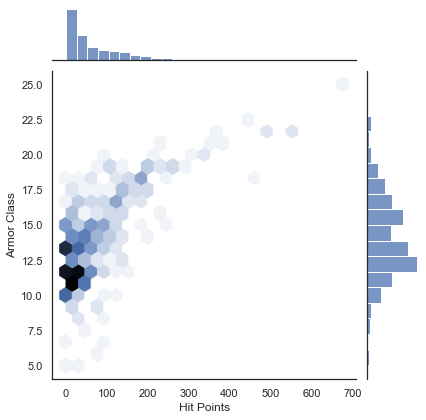

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(monster_df_wordless["Hit Points"], monster_df_wordless['Armor Class'], kind='hex');

In [ ]:
monster_df_wordless.to_csv('../data/processed/Monster_modeling_df.csv')

In [ ]:
# Create a stat only database for comparisons
monster_df_numeric = monster_df[['Hit Points', 'Armor Class','Proficiency Bonus', 'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA', 'Attack_Bonus', 'Challenge']]

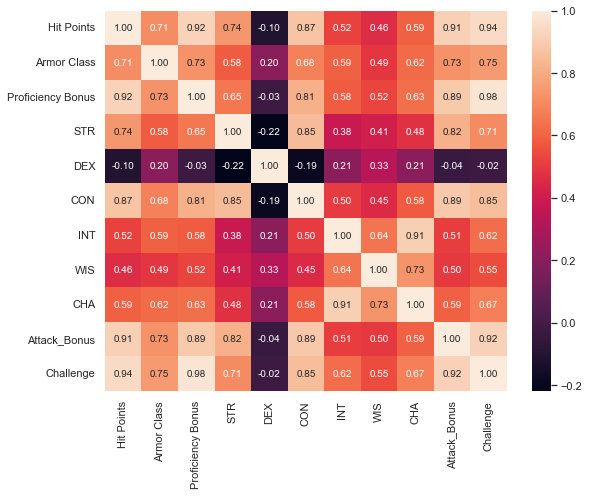

In [ ]:
fig = plt.figure(figsize = (9,7));
sns.heatmap(monster_df_numeric.corr(), annot = True, fmt = '.2f');

today i learned that in monsters, dexterity has no correlation to any other numeric stat including challenge rating. The closest thing is wisdom...so sometimes things that are wise are also dexterous which I think is hilarious. 

I don't think we will use Proficiency Bonus moving forward as it is really just linked to CR, so it won't tell us much. Basically, every CR that goes up, the proficiency goes up as well. Just like players levels

### Some quick line graphs
Looking at confidence interval as well

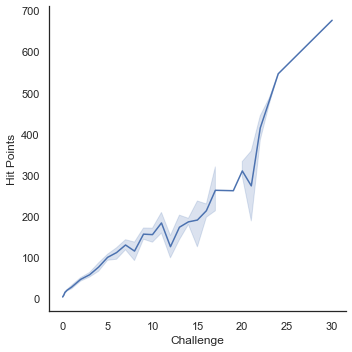

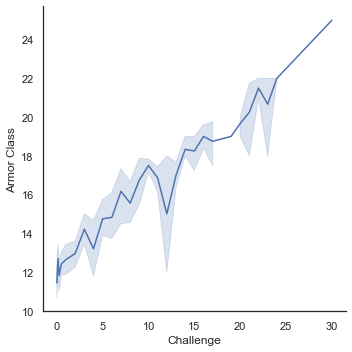

In [ ]:
hitpoint_line = sns.relplot(x = "Challenge", y = "Hit Points", kind = "line", data = monster_df_numeric)
armor_line =  sns.relplot(x = "Challenge", y = "Armor Class", kind = "line", data = monster_df_numeric)

### Pair grids are great for comparing the distributions of LOTS of items at once

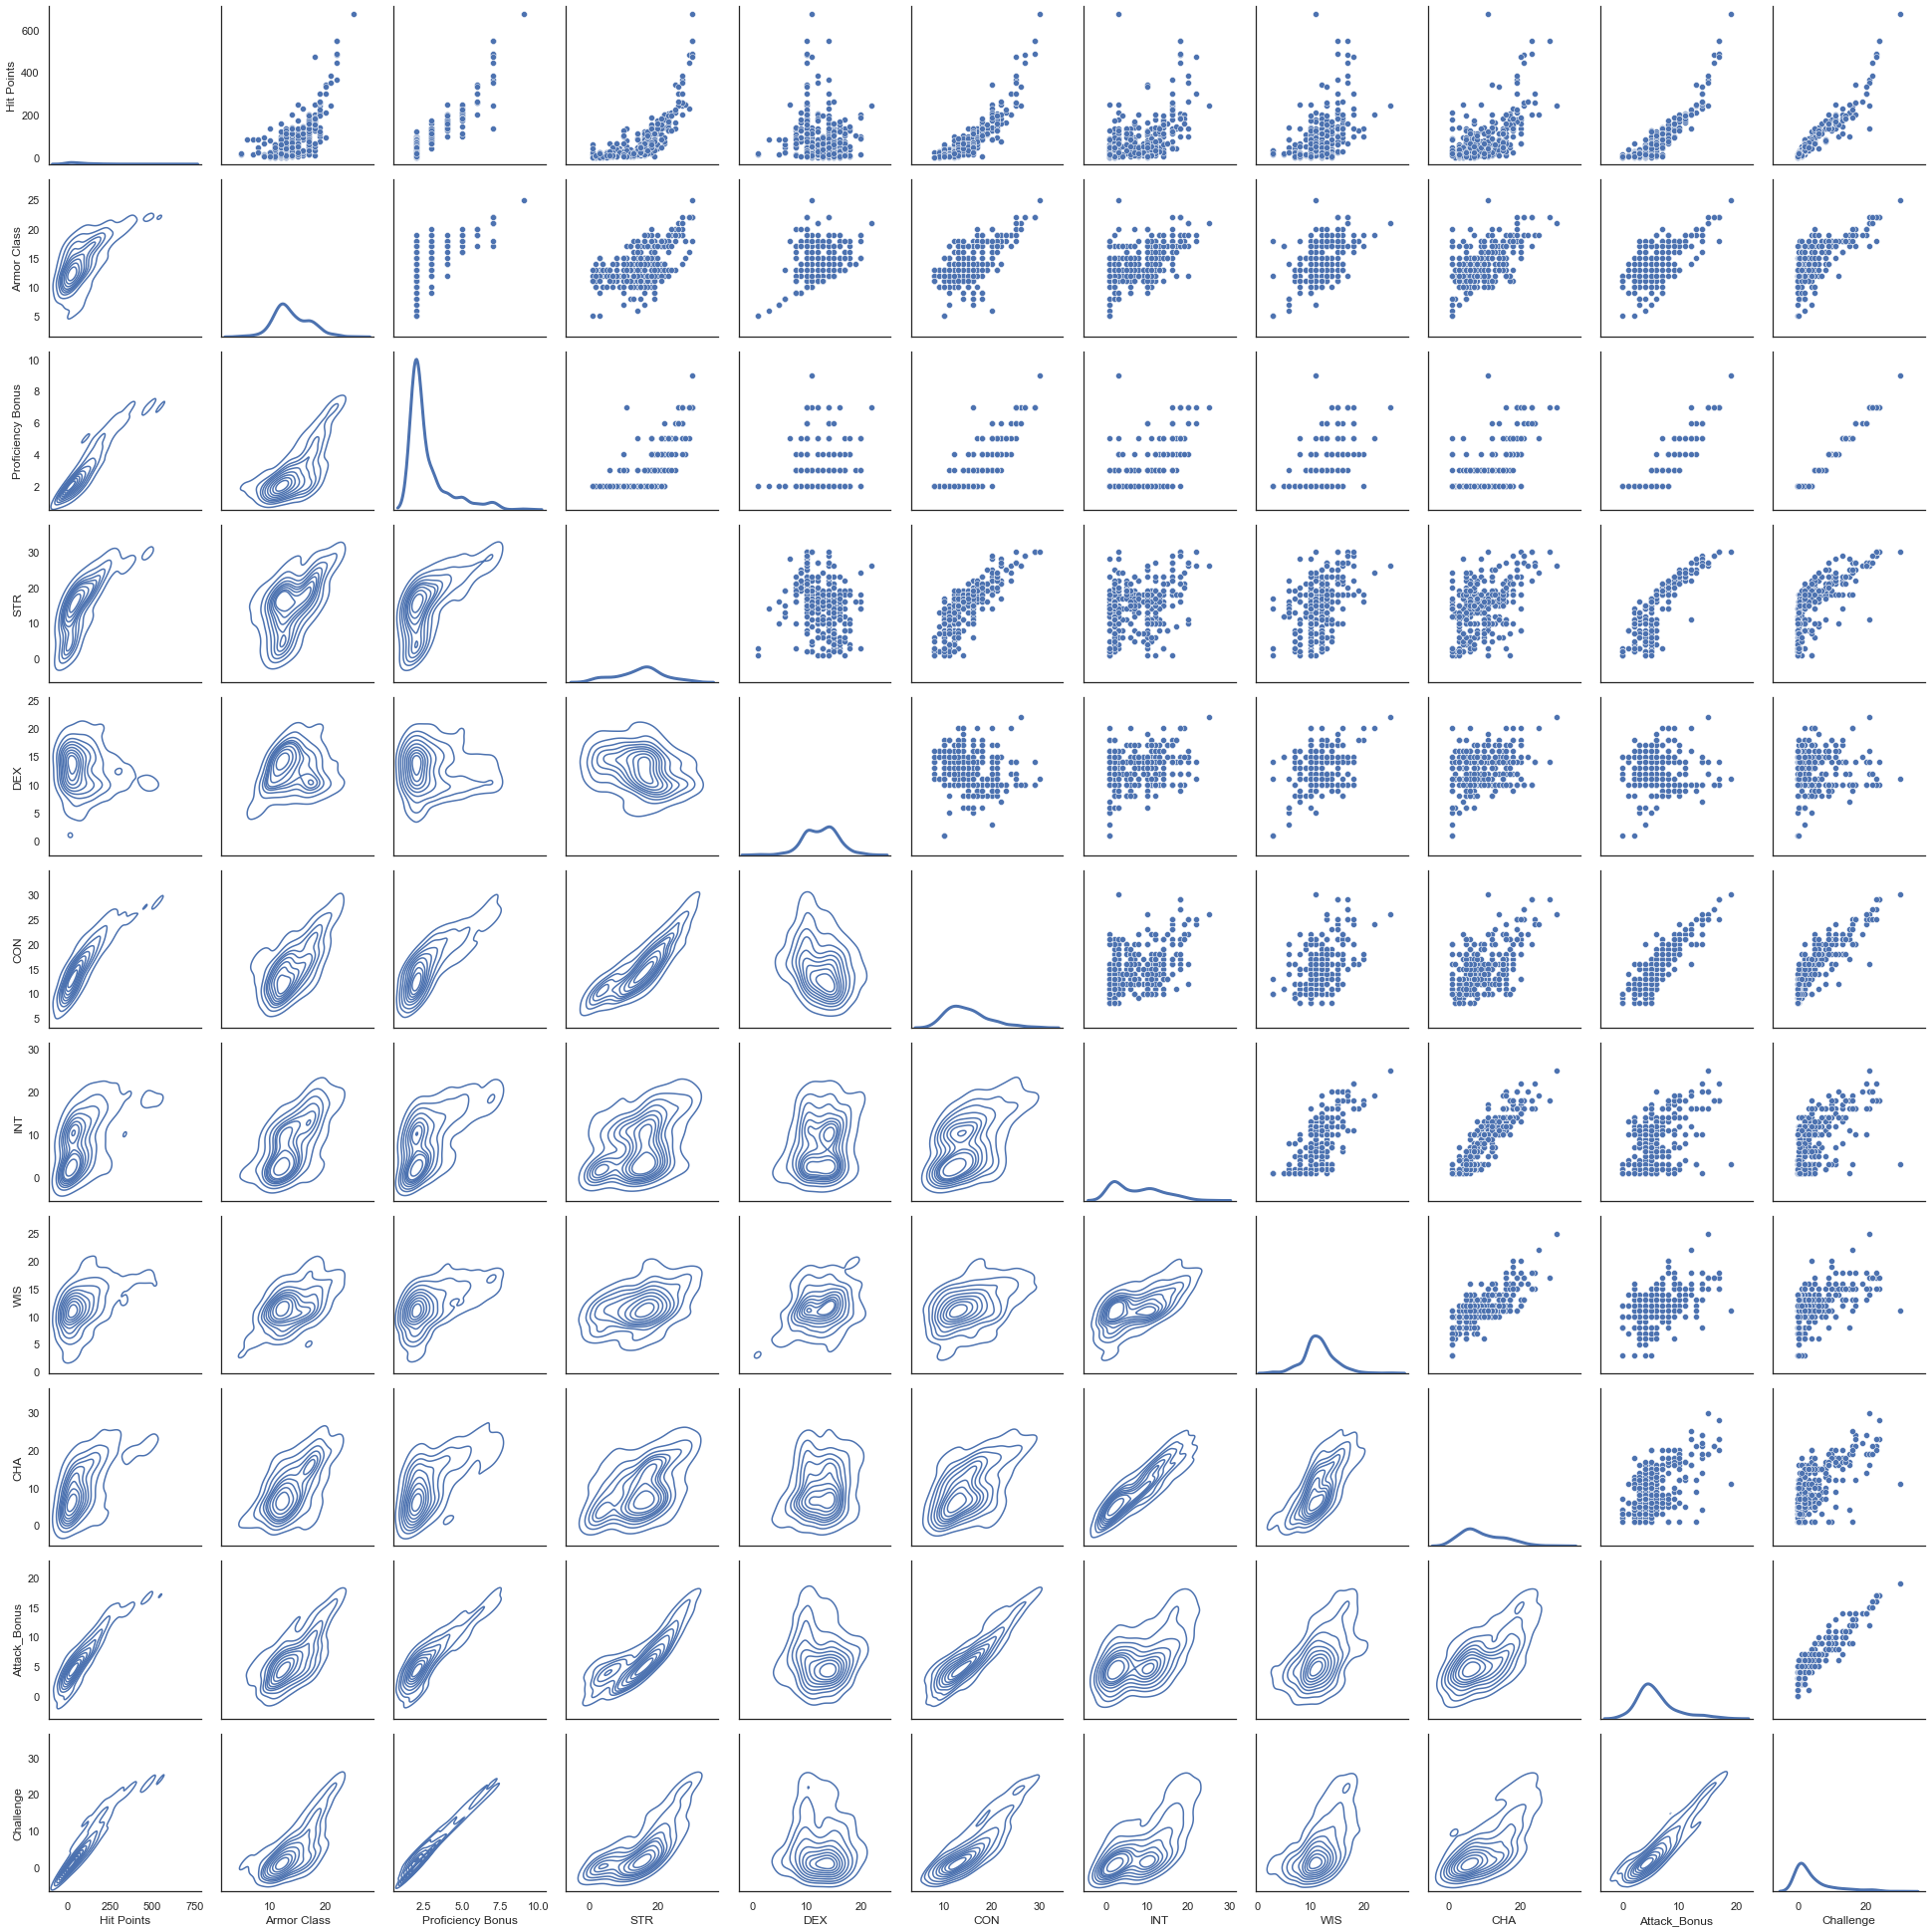

In [ ]:
compare_plots = sns.PairGrid(monster_df_numeric)
compare_plots.map_upper(sns.scatterplot)
compare_plots.map_lower(sns.kdeplot)
compare_plots.map_diag(sns.kdeplot,lw=3,legend=False)

<AxesSubplot:>

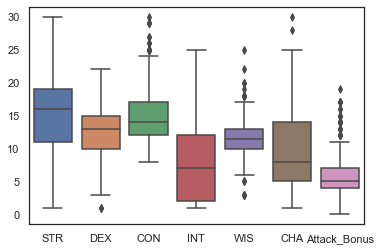

In [ ]:
stats_df = monster_df_numeric.drop(['Hit Points', 'Armor Class', 'Proficiency Bonus', 'Challenge'], axis = 1)
sns.boxplot(data=stats_df)

In [ ]:
# What are the really high CHA monsters? 
stats_df[stats_df['CHA']>25]

STR  DEX  CON  INT  WIS  CHA  Attack_Bonus
70    26   22   26   25   25   30            15
222   30   14   29   18   17   28            17

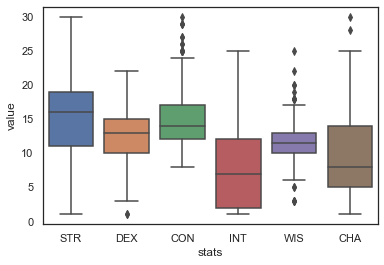

In [ ]:
df_melt = pd.melt(stats_df, value_vars=['STR', 'DEX', 'CON', 'INT','WIS','CHA'])

df_melt.columns = ['stats', 'value']

ax = sns.boxplot(x='stats', y='value', data=df_melt);
plt.show();


In [ ]:
# Anova of Stats
model = ols('value ~ C(stats)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq      df           F         PR(>F)
C(stats)  14931.113027     5.0  121.333093  6.702596e-113
Residual  51241.712644  2082.0         NaN            NaN

In [ ]:
# Pairwise analysis of stats
res = stat()
res.tukey_hsd(df=df_melt, res_var="value",xfac_var="stats",anova_model="value~C(stats)")
res.tukey_summary

'''Strength and Constitution are the only two no significantly different from one another, which definitely tracks. Dex and WIS coming in close again. SO strange'''

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\bioinfokit\analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


'Strength and Constitution are the only two no significantly different from one another, which definitely tracks. Dex and WIS coming in close again. SO strange'

## Bonus: WordClouds

In [ ]:
monster_df.isna().sum()

Monster Name                0
Size                        0
Type                        0
Alignment                   0
Traits                      0
Reactions                   0
Armor Class                 0
Hit Points                  0
Speed                       0
Challenge                   0
Proficiency Bonus           0
STR                         0
DEX                         0
CON                         0
INT                         0
WIS                         0
CHA                         0
Actions                     0
Legendary Actions           0
Environment                 0
Attack_Bonus                0
Spell_Bonus                 0
Spell_Save_DC               0
WIS_SV                      0
INT_SV                      0
CHA_SV                      0
STR_SV                      0
DEX_SV                      0
CON_SV                      0
Arctic                      0
Coastal                     0
Desert                      0
Forest                      0
Grassland 

In [ ]:
#Create a blob of text
action_text = " ".join(row for row in monster_df.Actions)

In [ ]:
dnd_logo = np.array(Image.open("../reports/figures/dnd_logo.jpeg"))

# Create stopword list
stopwords = set(STOPWORDS)
stopwords.update(['hit','ft',"NA'"])

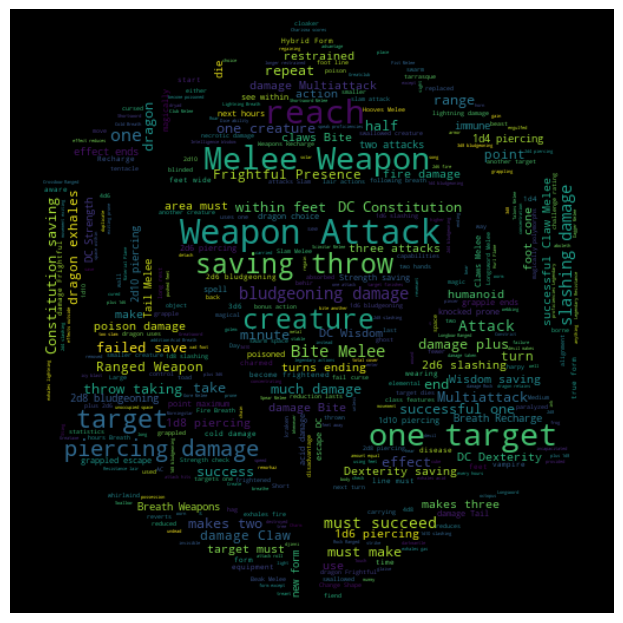

In [ ]:
# Wordcloud of action words
wc = WordCloud(background_color="black",stopwords=stopwords, max_words=2000, mask = dnd_logo, random_state=42, width=dnd_logo.shape[1],
               height=dnd_logo.shape[0])

wc.generate(action_text)
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()




In [ ]:
reaction_text = " ".join(row for row in monster_df.Reactions)

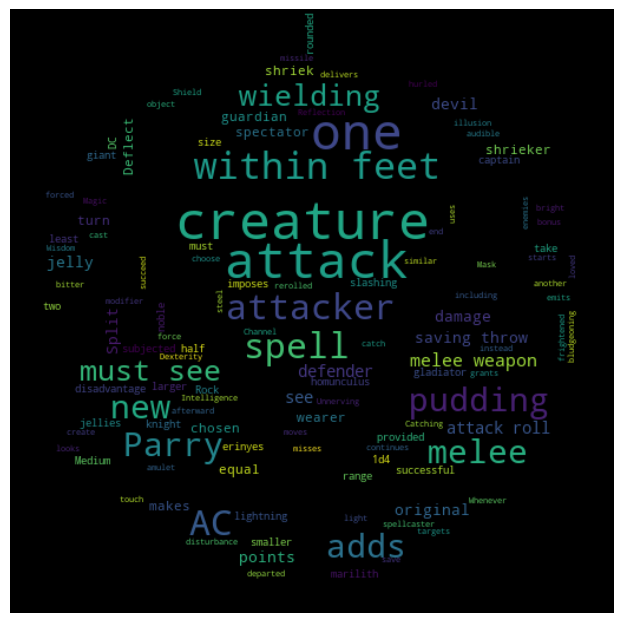

In [ ]:
# Wordcloud of reaction words
wc = WordCloud(background_color="black",stopwords=stopwords, max_words=2000, mask = dnd_logo, random_state=42, width=dnd_logo.shape[1],
               height=dnd_logo.shape[0])

wc.generate(reaction_text)
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# WHY ARE THERE SO MANY PUDDING REACTIONS
monster_df[monster_df['Reactions'].str.contains("pudding")]['Reactions']
#The reaction just used the word pudding a lot

7    ["Split. When a pudding that is Medium or larg...
Name: Reactions, dtype: object

In [ ]:
traits_text = " ".join(row for row in monster_df.Traits)

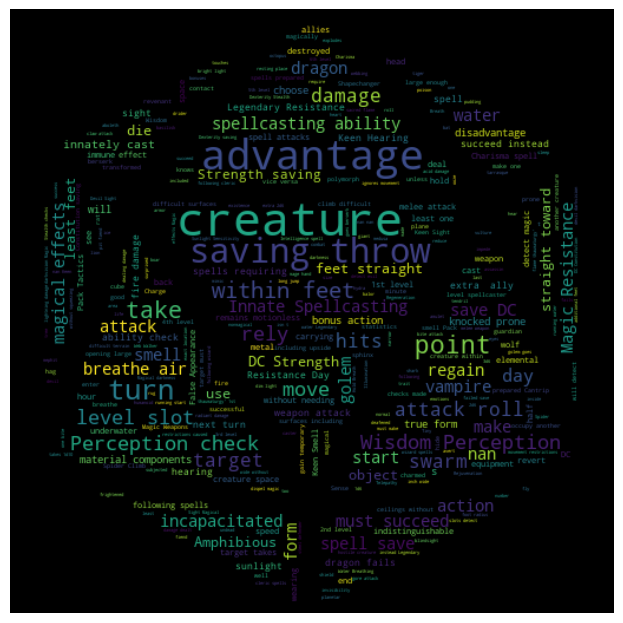

In [ ]:
wc = WordCloud(background_color="black",stopwords=stopwords, max_words=2000, mask = dnd_logo, random_state=42, width=dnd_logo.shape[1],
               height=dnd_logo.shape[0])

wc.generate(traits_text)
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
legendaryaction_text = " ".join(row for row in monster_df['Legendary Actions'])

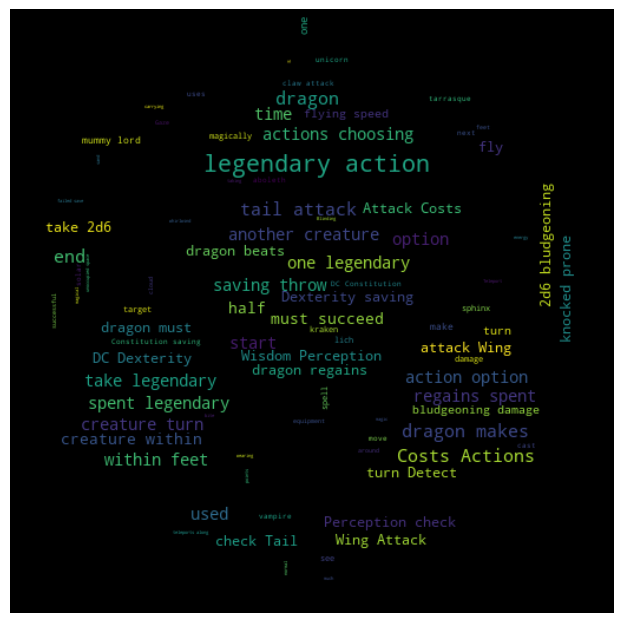

In [ ]:
wc = WordCloud(background_color="black",stopwords=stopwords, max_words=2000, mask = dnd_logo, random_state=42, width=dnd_logo.shape[1],
               height=dnd_logo.shape[0])

wc.generate(legendaryaction_text)
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Wordcloud of all available text
monster_df['Full_Text']= monster_df[['Legendary Actions', 'Traits','Reactions','Actions']].apply(' '.join,axis=1)
all_text= " ".join(row for row in monster_df['Full_Text'])

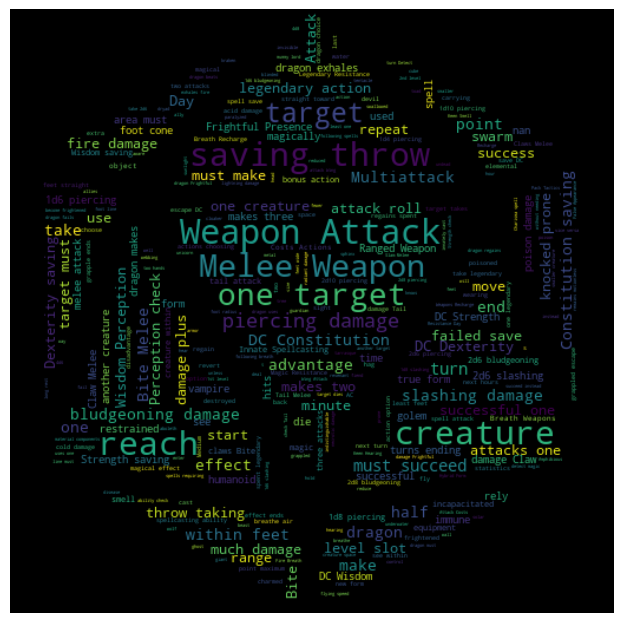

In [ ]:
wc = WordCloud(background_color="black",stopwords=stopwords, max_words=4000, mask = dnd_logo, random_state=42, width=dnd_logo.shape[1],
               height=dnd_logo.shape[0])

wc.generate(all_text)
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()